# GAN for MIDI Rhythm Generation

preprocess midi data with `0_preprocess_midi.ipynb` in advance

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # only relevant to my own environment

## Constants

In [2]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]
MIDI_DRUM_MAP = {
   36: 0,
   35: 0,
   38: 1,
   27: 1,
   28: 1,
   31: 1,
   32: 1,
   33: 1,
   34: 1,
   37: 1,
   39: 1,
   40: 1,
   56: 1,
   65: 1,
   66: 1,
   75: 1,
   85: 1,
   42: 2,
   44: 2,
   54: 2,
   68: 2,
   69: 2,
   70: 2,
   71: 2,
   73: 2,
   78: 2,
   80: 2,
   46: 3,
   67: 3,
   72: 3,
   74: 3,
   79: 3,
   81: 3,
   45: 4,
   29: 4,
   41: 4,
   61: 4,
   64: 4,
   84: 4,
   48: 5,
   47: 5,
   60: 5,
   63: 5,
   77: 5,
   86: 5,
   87: 5,
   50: 6,
   30: 6,
   43: 6,
   62: 6,
   76: 6,
   83: 6,
   49: 7,
   55: 7,
   57: 7,
   58: 7,
   51: 8,
   52: 8,
   53: 8,
   59: 8,
   82: 8
}

DRUM_MIDI_MAP = [ # pianoroll to MIDI - reverse
    36, # 0 Kick
    38, # 1 Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    45, # 4 Tom Low
    47, # 5 Tom Mid
    50, # 6 Tom High
    49, # 7 Clap
    51  # 8 Rim
]

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


# Training

In [3]:
import numpy as np

# load pianoroll matrix - see "0_preprocess_midi.ipynb"

matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

print(GENRES_ALL)
print(matrices_genres.shape)

# Filter genres 
GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
NB_GENRES = len(GENRES)

print(GENRES_ID_USED)
print(NB_GENRES, GENRES)

_drums = []
_genres = []

for genre_id, drum in zip(matrices_genres, matrices_drums):
    if genre_id in GENRES_ID_USED:
        _drums.append(drum)
        genre_id = GENRES_ID_USED.index(genre_id)
        _genres.append(genre_id)

matrices_drums = np.array(_drums)
print(matrices_drums.shape)
matrices_genres = np.array(_genres)
print(matrices_genres.shape)


['Old Skool' 'Trance' 'DnB' 'Basic' 'Downtempo' 'Jungle' 'House'
 'Breakbeat' 'Garage' 'Techno']
(49003,)
[0, 2, 5, 6, 7, 8, 9]
7 ['Old Skool', 'DnB', 'Jungle', 'House', 'Breakbeat', 'Garage', 'Techno']
(37950, 32, 9)
(37950,)


## Discriminator

In [4]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional
from keras.layers import Embedding, Concatenate
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential

batch_size = 16
n_z = 4
dropout_rate = 0.30

# encoder
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order

x = Bidirectional(LSTM(256, return_sequences=True, activation='tanh'))(drum_input) 
x = Bidirectional(LSTM(256, return_sequences=False, activation='tanh'))(x)
# x = Bidirectional(LSTM(16, return_sequences=False, activation='tanh'))(x)
# x = Reshape((1024,))(x)
# x = Dense(512)(x)
# x = LeakyReLU(alpha=0.01)(x)
x = Dense(256)(x)
# x = LeakyReLU(alpha=0.01)(x)
output = Dense(1, activation='sigmoid')(x)

discriminator = Model(drum_input, output)
discriminator.summary()

optimizer = RMSprop ( lr = 0.0008 )  # higher leraning rate for D
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', 
                      metrics=['accuracy'])

/home/tokui/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tokui/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tokui/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tokui/anaconda3/lib/python3.6/site-packages/

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
drum_input (InputLayer)      (None, 32, 9)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 512)           544768    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,251,265
Trainable params: 2,251,265
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## GENERATOR 

In [5]:
from keras.layers import Reshape, Conv2DTranspose, RepeatVector, Activation,Bidirectional,multiply
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D

len_input = 256

z_input = Input(shape=(len_input,))  # tensorflow order

# x = Dense(512)(z_input)
# x = LeakyReLU(alpha=0.2)(x)
# x = BatchNormalization(momentum=0.9)(x)
x = Dense(1024)(z_input)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(momentum=0.9)(x)
x = Reshape((32, 32))(x)
x = Dropout(dropout_rate)(x)

x = LSTM(256, return_sequences=True, activation='tanh')(x) 
x = LSTM(256, return_sequences=True, activation='tanh')(x)
note_out = LSTM(9, return_sequences=True, activation='sigmoid')(x)

generator = Model(z_input, note_out)
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              263168    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32, 256)           2959

## ADVERSARIAL MODEL 

In [6]:

from keras.models import Sequential


# define input for the combined GAN model
z_input = Input(shape=(len_input,))  # tensorflow order
img_gan = generator(z_input)

# training is disable for discriminator in adversarial model
discriminator.trainable = False 

# define output
prediction_gan = discriminator(img_gan)

# define combined GAN model
gan = Model(z_input, prediction_gan)

optimizer = RMSprop ( lr = 0.0004 )
gan.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256)               0         
_________________________________________________________________
model_2 (Model)              (None, 32, 9)             1098088   
_________________________________________________________________
model_1 (Model)              (None, 1)                 2251265   
Total params: 3,349,353
Trainable params: 1,096,040
Non-trainable params: 2,253,313
_________________________________________________________________


In [7]:
print(gan.metrics_names)
print (discriminator.metrics_names)


['loss', 'binary_accuracy']
['loss', 'accuracy']


## Training

In [8]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import random
import pretty_midi
from IPython.display import Audio
from scipy.io import wavfile

# Create Z for generator
def get_noise(batch_size, len_input):
#    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, len_input])
    
    # better to use a spherical Z. according to https://github.com/soumith/ganhacks
    noise = np.random.normal(0.0, 1.0, size=[batch_size, len_input])
    return noise

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  
        
        import pretty_midi

def play_drum_matrix(mat, tempo=120.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, tempo=tempo)
    display(Audio(audio_data, rate=44100))
    return audio_data

def get_audio_from_drum_matrix(mat, tempo=120.):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    for position, timeslot in enumerate(mat):
        for inst, onset in enumerate(timeslot):
            if onset > 0.:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                start = timestep * position
                end = timestep * (position + 0.5)
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data

In [9]:
from tensorboard_logger import configure, log_value

from datetime import datetime
now = datetime.now()
logdir = "/tmp/tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"
cmd = "tensorboard --logdir=" + logdir
print (cmd)

configure(logdir, flush_secs=5)

tensorboard --logdir=/tmp/tf_logs/20191126-143641/


d_loss_real [0.00023386953, 1.0]
d_loss_fake [0.011095878, 1.0]
epoch 30 0
d_loss 0.005664873868227005 a_loss 7.205031
d_accuracy 1.0


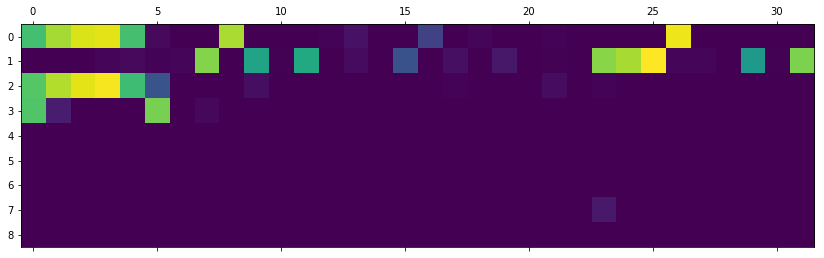

d_loss_real [0.00029127244, 1.0]
d_loss_fake [0.0018042147, 1.0]
d_loss_real [9.099739e-05, 1.0]
d_loss_fake [0.0074987765, 1.0]
d_loss_real [0.021251021, 1.0]
d_loss_fake [0.17896985, 0.9375]
d_loss_real [0.0075060725, 1.0]
d_loss_fake [0.0012614701, 1.0]
d_loss_real [0.004721844, 1.0]
d_loss_fake [0.00070838106, 1.0]
d_loss_real [8.333404e-05, 1.0]
d_loss_fake [0.0007471872, 1.0]
d_loss_real [0.0003265828, 1.0]
d_loss_fake [0.0006811437, 1.0]
d_loss_real [0.07905127, 0.96875]
d_loss_fake [0.002426396, 1.0]
d_loss_real [0.0011533333, 1.0]
d_loss_fake [0.004368956, 1.0]
d_loss_real [0.00029393303, 1.0]
d_loss_fake [0.0010149039, 1.0]
d_loss_real [0.018492235, 1.0]
d_loss_fake [0.0010012046, 1.0]
d_loss_real [0.00049280585, 1.0]
d_loss_fake [0.00053220236, 1.0]
d_loss_real [0.0024938027, 1.0]
d_loss_fake [0.0004936083, 1.0]
d_loss_real [5.60084e-05, 1.0]
d_loss_fake [0.0003676784, 1.0]
d_loss_real [0.00067131035, 1.0]
d_loss_fake [0.0001873246, 1.0]
d_loss_real [0.0033711058, 1.0]
d_los

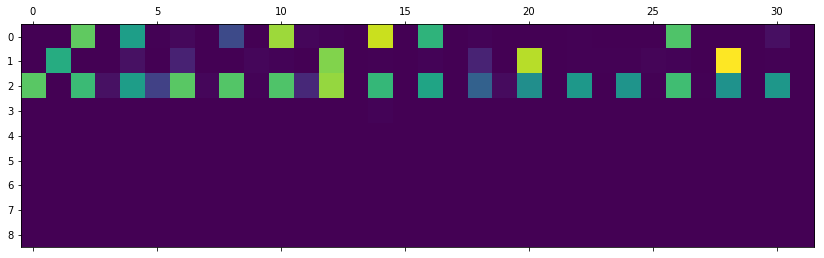

d_loss_real [1.16660585e-05, 1.0]
d_loss_fake [0.0014065083, 1.0]
d_loss_real [0.0047525326, 1.0]
d_loss_fake [0.0006977105, 1.0]
d_loss_real [0.0010552432, 1.0]
d_loss_fake [0.00041273737, 1.0]
d_loss_real [0.0023868396, 1.0]
d_loss_fake [0.00031148392, 1.0]
d_loss_real [0.02190636, 1.0]
d_loss_fake [0.0009125264, 1.0]
d_loss_real [0.00045385494, 1.0]
d_loss_fake [0.007297575, 1.0]
d_loss_real [0.0016030163, 1.0]
d_loss_fake [0.000108861845, 1.0]
d_loss_real [1.9700128e-06, 1.0]
d_loss_fake [0.0029445814, 1.0]
d_loss_real [0.002553444, 1.0]
d_loss_fake [7.8153185e-05, 1.0]
d_loss_real [0.02110274, 1.0]
d_loss_fake [0.0059553594, 1.0]
d_loss_real [2.218275e-07, 1.0]
d_loss_fake [0.023185886, 1.0]
d_loss_real [2.0560253e-07, 1.0]
d_loss_fake [0.00026059573, 1.0]
d_loss_real [0.22577721, 0.96875]
d_loss_fake [0.19774501, 0.96875]
d_loss_real [0.0012711925, 1.0]
d_loss_fake [0.0022256505, 1.0]
d_loss_real [0.0017904057, 1.0]
d_loss_fake [0.0018101298, 1.0]
d_loss_real [0.18359116, 0.96875

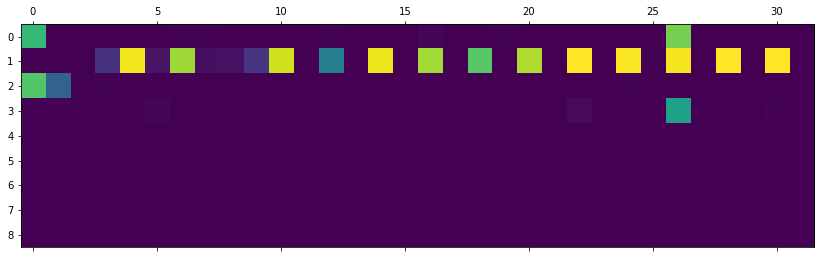

d_loss_real [0.00019454434, 1.0]
d_loss_fake [0.00032292758, 1.0]
d_loss_real [3.9462157e-05, 1.0]
d_loss_fake [0.115218006, 0.96875]
d_loss_real [0.0004683462, 1.0]
d_loss_fake [0.0022569578, 1.0]
d_loss_real [0.0002792764, 1.0]
d_loss_fake [0.0015189839, 1.0]
d_loss_real [0.00044364465, 1.0]
d_loss_fake [0.0802841, 0.96875]
d_loss_real [0.07652812, 0.96875]
d_loss_fake [0.0031812093, 1.0]
d_loss_real [0.00029831228, 1.0]
d_loss_fake [0.005845012, 1.0]
d_loss_real [0.0012215866, 1.0]
d_loss_fake [0.0008914425, 1.0]
d_loss_real [0.01880049, 1.0]
d_loss_fake [0.0007327091, 1.0]
d_loss_real [6.599733e-05, 1.0]
d_loss_fake [0.0002923287, 1.0]
d_loss_real [0.00019701694, 1.0]
d_loss_fake [0.001301079, 1.0]
d_loss_real [0.076705046, 0.96875]
d_loss_fake [0.5100767, 0.8125]
d_loss_real [0.008605593, 1.0]
d_loss_fake [0.0020572315, 1.0]
d_loss_real [0.006782464, 1.0]
d_loss_fake [0.0018029332, 1.0]
d_loss_real [0.00011522848, 1.0]
d_loss_fake [0.0011595224, 1.0]
d_loss_real [0.17374647, 0.968

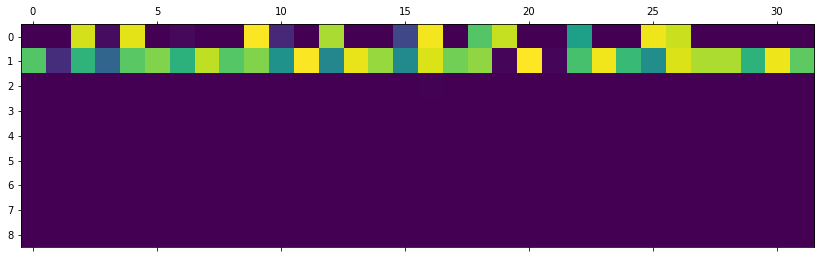

d_loss_real [0.22776812, 0.96875]
d_loss_fake [0.0036649562, 1.0]
d_loss_real [8.1189755e-05, 1.0]
d_loss_fake [0.0017069525, 1.0]
d_loss_real [0.21137735, 0.90625]
d_loss_fake [0.040684797, 1.0]
d_loss_real [0.0011071619, 1.0]
d_loss_fake [0.0018926228, 1.0]
d_loss_real [0.002976576, 1.0]
d_loss_fake [0.0006677762, 1.0]
d_loss_real [0.0012045308, 1.0]
d_loss_fake [0.0012888846, 1.0]
d_loss_real [0.000569541, 1.0]
d_loss_fake [0.0009857116, 1.0]
d_loss_real [0.0032863324, 1.0]
d_loss_fake [0.0068199444, 1.0]
d_loss_real [0.0031037312, 1.0]
d_loss_fake [0.00033356267, 1.0]
d_loss_real [0.08408471, 0.96875]
d_loss_fake [0.07776933, 0.96875]
d_loss_real [0.1530534, 0.96875]
d_loss_fake [0.0028798883, 1.0]
d_loss_real [0.0030033994, 1.0]
d_loss_fake [0.0042416966, 1.0]
d_loss_real [0.040629625, 0.96875]
d_loss_fake [0.006727697, 1.0]
d_loss_real [0.0006878958, 1.0]
d_loss_fake [0.0014699302, 1.0]
d_loss_real [0.001359873, 1.0]
d_loss_fake [0.0017760929, 1.0]
d_loss_real [0.0042201956, 1.0]

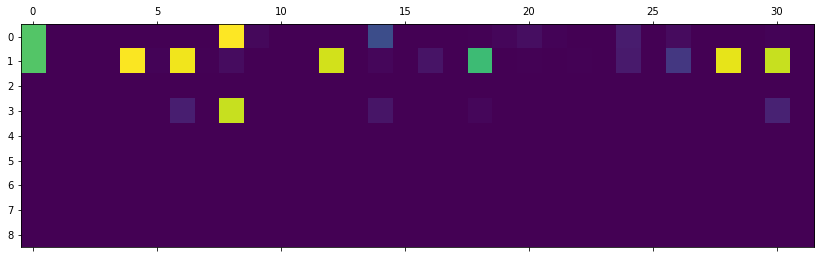

d_loss_real [0.00057587377, 1.0]
d_loss_fake [0.0007721813, 1.0]
d_loss_real [0.0006481557, 1.0]
d_loss_fake [0.0006278196, 1.0]
d_loss_real [0.009558948, 1.0]
d_loss_fake [0.0032784021, 1.0]
d_loss_real [0.0002149796, 1.0]
d_loss_fake [0.0010160757, 1.0]
d_loss_real [0.26309434, 0.9375]
d_loss_fake [0.016433083, 1.0]
d_loss_real [0.0008168264, 1.0]
d_loss_fake [0.0013941076, 1.0]
d_loss_real [0.00039620546, 1.0]
d_loss_fake [0.0038608394, 1.0]
d_loss_real [8.254894e-05, 1.0]
d_loss_fake [0.0013149253, 1.0]
d_loss_real [6.5034474e-05, 1.0]
d_loss_fake [0.0016328939, 1.0]
d_loss_real [0.0013238157, 1.0]
d_loss_fake [0.00055112876, 1.0]
d_loss_real [0.00024870233, 1.0]
d_loss_fake [0.00058970717, 1.0]
d_loss_real [0.005216388, 1.0]
d_loss_fake [0.09512132, 0.96875]
d_loss_real [0.001933679, 1.0]
d_loss_fake [0.0009624233, 1.0]
d_loss_real [0.00036691682, 1.0]
d_loss_fake [0.0023928722, 1.0]
d_loss_real [0.00029079165, 1.0]
d_loss_fake [0.0012113579, 1.0]
d_loss_real [7.415624e-05, 1.0]
d

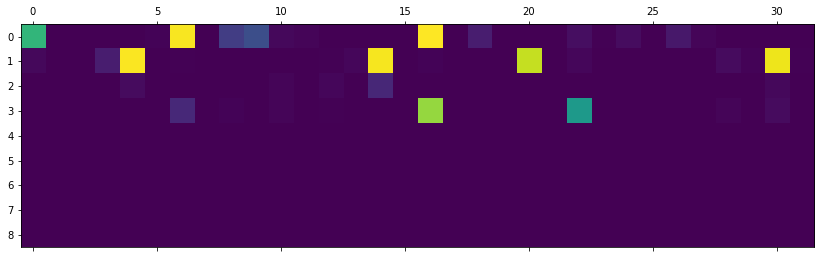

d_loss_real [0.0031058912, 1.0]
d_loss_fake [0.0006992252, 1.0]
d_loss_real [0.00097610755, 1.0]
d_loss_fake [0.0015579201, 1.0]
d_loss_real [0.00029725133, 1.0]
d_loss_fake [0.095656544, 0.9375]
d_loss_real [0.0016605231, 1.0]
d_loss_fake [0.0013269049, 1.0]
d_loss_real [0.19842036, 0.96875]
d_loss_fake [0.01766507, 1.0]
d_loss_real [0.091560334, 0.90625]
d_loss_fake [0.001958149, 1.0]
d_loss_real [0.14773016, 0.96875]
d_loss_fake [0.009041231, 1.0]
d_loss_real [0.22318156, 0.9375]
d_loss_fake [0.03399257, 1.0]
d_loss_real [0.004816383, 1.0]
d_loss_fake [0.015047076, 1.0]
d_loss_real [0.18467952, 0.9375]
d_loss_fake [0.041664835, 1.0]
d_loss_real [0.002653342, 1.0]
d_loss_fake [0.026087198, 1.0]
d_loss_real [0.00013626728, 1.0]
d_loss_fake [0.00790908, 1.0]
d_loss_real [0.064162835, 0.96875]
d_loss_fake [0.13051671, 0.96875]
d_loss_real [0.00045247248, 1.0]
d_loss_fake [0.006468472, 1.0]
d_loss_real [0.00030005217, 1.0]
d_loss_fake [0.005387348, 1.0]
d_loss_real [0.0068052276, 1.0]
d_

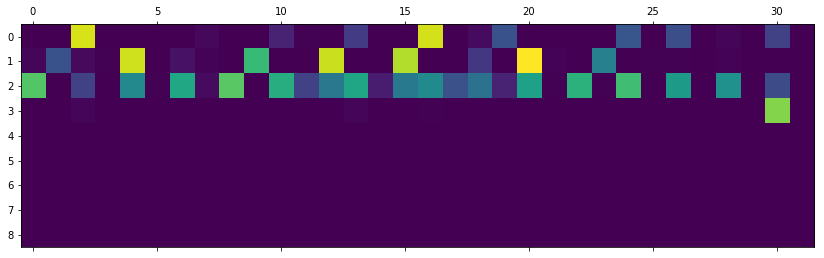

d_loss_real [0.0010706598, 1.0]
d_loss_fake [0.0016935265, 1.0]
d_loss_real [0.028943008, 0.96875]
d_loss_fake [0.0022071756, 1.0]
d_loss_real [0.0006769563, 1.0]
d_loss_fake [0.0011007776, 1.0]
d_loss_real [0.19668856, 0.96875]
d_loss_fake [0.03150268, 1.0]
d_loss_real [0.00029186613, 1.0]
d_loss_fake [0.0027390895, 1.0]
d_loss_real [0.14783624, 0.96875]
d_loss_fake [0.020260327, 1.0]
d_loss_real [0.0031810806, 1.0]
d_loss_fake [0.0032809395, 1.0]
d_loss_real [0.00068050553, 1.0]
d_loss_fake [0.004172823, 1.0]
d_loss_real [0.00016114995, 1.0]
d_loss_fake [0.0032189516, 1.0]
d_loss_real [0.0071652858, 1.0]
d_loss_fake [0.0027893567, 1.0]
d_loss_real [0.0015839429, 1.0]
d_loss_fake [0.0011621471, 1.0]
d_loss_real [0.013750749, 1.0]
d_loss_fake [0.00185066, 1.0]
d_loss_real [0.010744689, 1.0]
d_loss_fake [0.003416994, 1.0]
d_loss_real [0.001598799, 1.0]
d_loss_fake [0.00039600497, 1.0]
d_loss_real [9.8645134e-05, 1.0]
d_loss_fake [0.030430729, 0.96875]
d_loss_real [1.2727956e-05, 1.0]
d_

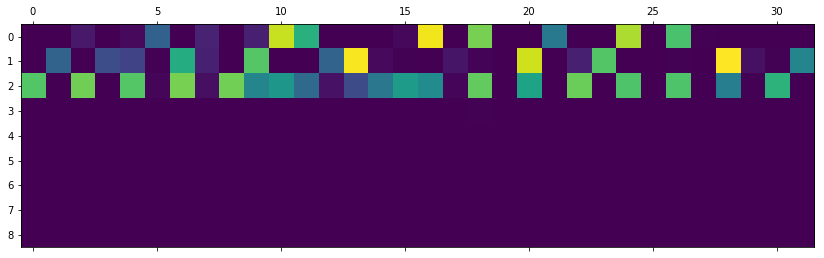

d_loss_real [0.0005964791, 1.0]
d_loss_fake [0.002127527, 1.0]
d_loss_real [0.00051750726, 1.0]
d_loss_fake [0.0013994098, 1.0]
d_loss_real [0.00048767016, 1.0]
d_loss_fake [0.002314265, 1.0]
d_loss_real [0.102704525, 0.96875]
d_loss_fake [0.0054592276, 1.0]
d_loss_real [0.008373962, 1.0]
d_loss_fake [0.0033473661, 1.0]
d_loss_real [0.00033689168, 1.0]
d_loss_fake [0.018329836, 1.0]
d_loss_real [0.00013102927, 1.0]
d_loss_fake [0.005802611, 1.0]
d_loss_real [0.00080792187, 1.0]
d_loss_fake [0.005388364, 1.0]
d_loss_real [1.3089734e-06, 1.0]
d_loss_fake [0.00035303194, 1.0]
d_loss_real [6.8614194e-05, 1.0]
d_loss_fake [0.0024883093, 1.0]
d_loss_real [0.010026043, 1.0]
d_loss_fake [0.00047661542, 1.0]
d_loss_real [3.6032412e-05, 1.0]
d_loss_fake [0.0008707625, 1.0]
d_loss_real [0.046938557, 0.96875]
d_loss_fake [0.068766125, 0.96875]
d_loss_real [0.02176612, 1.0]
d_loss_fake [0.20312703, 0.96875]
d_loss_real [0.0003397612, 1.0]
d_loss_fake [0.0043318057, 1.0]
d_loss_real [0.000109510394,

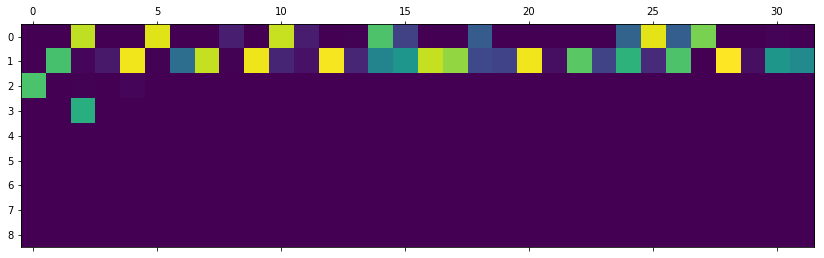

d_loss_real [0.00026728268, 1.0]
d_loss_fake [0.018598242, 1.0]
d_loss_real [0.00024064645, 1.0]
d_loss_fake [0.0008738921, 1.0]
d_loss_real [0.2021446, 0.96875]
d_loss_fake [0.016524132, 1.0]
d_loss_real [0.00043500282, 1.0]
d_loss_fake [0.003643807, 1.0]
d_loss_real [0.0002795176, 1.0]
d_loss_fake [0.002008014, 1.0]
d_loss_real [0.010880021, 1.0]
d_loss_fake [0.0022753053, 1.0]
d_loss_real [0.0141641805, 1.0]
d_loss_fake [0.09098183, 0.96875]
d_loss_real [0.00019308299, 1.0]
d_loss_fake [0.14576618, 0.96875]
d_loss_real [0.0047039543, 1.0]
d_loss_fake [0.0131860245, 1.0]
d_loss_real [0.0393557, 0.96875]
d_loss_fake [0.14926423, 0.96875]
d_loss_real [0.130066, 0.9375]
d_loss_fake [0.02764649, 1.0]
d_loss_real [0.052455567, 0.96875]
d_loss_fake [0.012841557, 1.0]
d_loss_real [0.0009013938, 1.0]
d_loss_fake [0.015501916, 1.0]
d_loss_real [0.0019987458, 1.0]
d_loss_fake [0.0049774093, 1.0]
d_loss_real [0.0039505134, 1.0]
d_loss_fake [0.0040671937, 1.0]
d_loss_real [0.0037140818, 1.0]
d_l

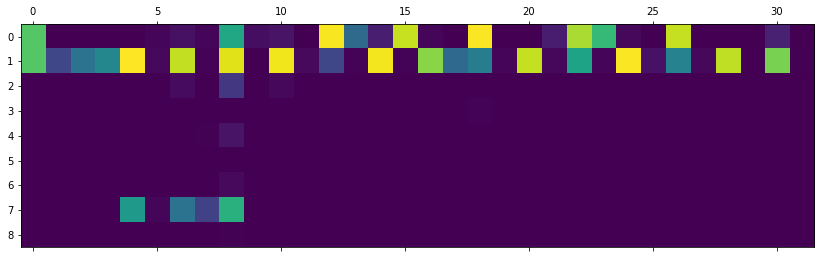

d_loss_real [0.02173951, 1.0]
d_loss_fake [0.0031573386, 1.0]
d_loss_real [0.034155037, 0.96875]
d_loss_fake [0.0021484992, 1.0]
d_loss_real [0.00011226235, 1.0]
d_loss_fake [0.019078566, 1.0]
d_loss_real [0.00020912969, 1.0]
d_loss_fake [0.0009853708, 1.0]
d_loss_real [5.0542832e-05, 1.0]
d_loss_fake [0.014312881, 1.0]
d_loss_real [0.0006335536, 1.0]
d_loss_fake [0.0016139557, 1.0]
d_loss_real [0.0003826477, 1.0]
d_loss_fake [0.010865524, 1.0]
d_loss_real [0.0003954142, 1.0]
d_loss_fake [0.06672024, 0.96875]
d_loss_real [0.0019138997, 1.0]
d_loss_fake [0.0003152806, 1.0]
d_loss_real [0.014841521, 1.0]
d_loss_fake [0.0006955569, 1.0]
d_loss_real [0.00041879917, 1.0]
d_loss_fake [0.00145782, 1.0]
d_loss_real [0.005846913, 1.0]
d_loss_fake [0.001313363, 1.0]
d_loss_real [7.974378e-05, 1.0]
d_loss_fake [0.00013728425, 1.0]
d_loss_real [0.0031879542, 1.0]
d_loss_fake [0.0002921524, 1.0]
d_loss_real [3.4060456e-06, 1.0]
d_loss_fake [0.031775173, 0.96875]
d_loss_real [3.5076126e-05, 1.0]
d_l

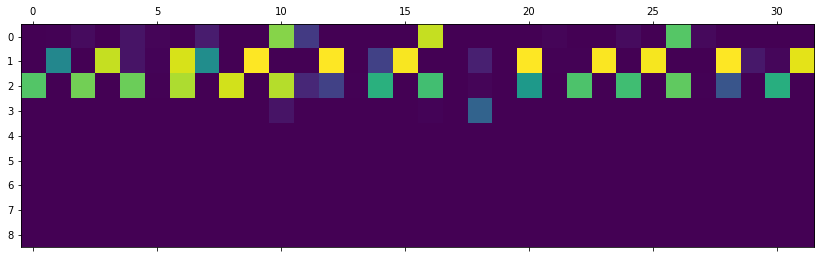

d_loss_real [0.009789853, 1.0]
d_loss_fake [0.0012530965, 1.0]
d_loss_real [0.0004918304, 1.0]
d_loss_fake [0.0029127314, 1.0]
d_loss_real [0.00034397093, 1.0]
d_loss_fake [0.0023909337, 1.0]
d_loss_real [0.023631318, 1.0]
d_loss_fake [0.10412412, 0.96875]
d_loss_real [0.026297212, 0.96875]
d_loss_fake [0.0008620813, 1.0]
d_loss_real [0.23425193, 0.96875]
d_loss_fake [0.01749563, 1.0]
d_loss_real [0.00035303732, 1.0]
d_loss_fake [0.008436356, 1.0]
d_loss_real [0.098622635, 0.96875]
d_loss_fake [0.006679233, 1.0]
d_loss_real [0.0013029546, 1.0]
d_loss_fake [0.021096569, 1.0]
d_loss_real [0.00057332416, 1.0]
d_loss_fake [0.010374717, 1.0]
d_loss_real [0.0054878965, 1.0]
d_loss_fake [0.0013602339, 1.0]
d_loss_real [0.0011257847, 1.0]
d_loss_fake [0.0014809386, 1.0]
d_loss_real [0.00083772995, 1.0]
d_loss_fake [0.0012794841, 1.0]
d_loss_real [8.4393796e-05, 1.0]
d_loss_fake [0.0022275771, 1.0]
d_loss_real [0.00074351195, 1.0]
d_loss_fake [0.007384643, 1.0]
d_loss_real [0.39039525, 0.9375]


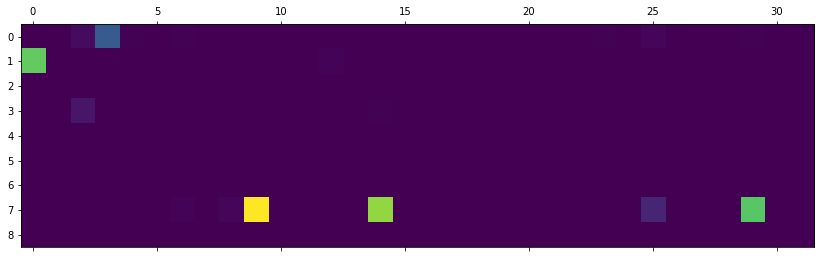

d_loss_real [0.00049754826, 1.0]
d_loss_fake [0.012871992, 1.0]
d_loss_real [0.00080013537, 1.0]
d_loss_fake [0.00839886, 1.0]
d_loss_real [0.00036015752, 1.0]
d_loss_fake [0.0009662532, 1.0]
d_loss_real [0.0013274213, 1.0]
d_loss_fake [0.07861555, 0.96875]
d_loss_real [0.0017549255, 1.0]
d_loss_fake [0.0026952093, 1.0]
d_loss_real [0.0010277863, 1.0]
d_loss_fake [0.0015890698, 1.0]
d_loss_real [0.0072396323, 1.0]
d_loss_fake [0.0011646687, 1.0]
d_loss_real [0.1310476, 0.9375]
d_loss_fake [0.006357733, 1.0]
d_loss_real [0.006682409, 1.0]
d_loss_fake [0.0017243836, 1.0]
d_loss_real [0.14688222, 0.96875]
d_loss_fake [0.015046696, 1.0]
d_loss_real [0.013659481, 1.0]
d_loss_fake [0.024047146, 1.0]
d_loss_real [0.001521316, 1.0]
d_loss_fake [0.0047960803, 1.0]
d_loss_real [0.23612104, 0.96875]
d_loss_fake [0.030387662, 1.0]
d_loss_real [0.0035517635, 1.0]
d_loss_fake [0.04407127, 0.96875]
d_loss_real [0.0009996246, 1.0]
d_loss_fake [0.0030966168, 1.0]
d_loss_real [0.008540156, 1.0]
d_loss_f

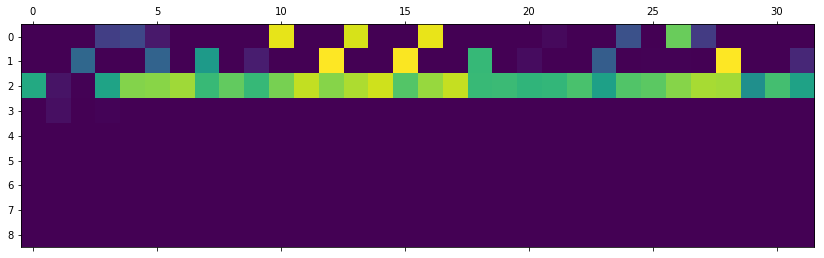

d_loss_real [0.00071494974, 1.0]
d_loss_fake [0.00083910074, 1.0]
d_loss_real [0.1639102, 0.96875]
d_loss_fake [0.015536235, 1.0]
d_loss_real [0.0010981574, 1.0]
d_loss_fake [0.008676928, 1.0]
d_loss_real [0.0012812094, 1.0]
d_loss_fake [0.0018878018, 1.0]
d_loss_real [0.0013742463, 1.0]
d_loss_fake [0.009363613, 1.0]
d_loss_real [0.000116115836, 1.0]
d_loss_fake [0.0014532851, 1.0]
d_loss_real [0.000694749, 1.0]
d_loss_fake [0.017833348, 1.0]
d_loss_real [0.0007953084, 1.0]
d_loss_fake [0.0010841053, 1.0]
d_loss_real [5.979916e-05, 1.0]
d_loss_fake [0.0014868501, 1.0]
d_loss_real [0.00030708907, 1.0]
d_loss_fake [0.0003113507, 1.0]
d_loss_real [0.00022689112, 1.0]
d_loss_fake [0.00047429118, 1.0]
d_loss_real [0.00041635576, 1.0]
d_loss_fake [0.00033288257, 1.0]
d_loss_real [0.07647771, 0.96875]
d_loss_fake [0.0010249609, 1.0]
d_loss_real [0.00011536642, 1.0]
d_loss_fake [0.0016779349, 1.0]
d_loss_real [0.02915931, 0.96875]
d_loss_fake [0.01227863, 1.0]
d_loss_real [2.1508435e-05, 1.0]

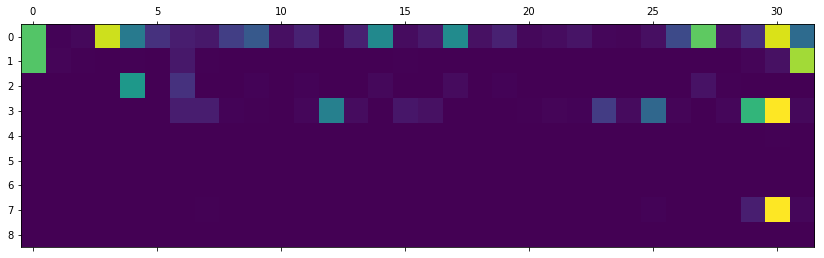

d_loss_real [5.056838e-05, 1.0]
d_loss_fake [0.0022798332, 1.0]
d_loss_real [0.0020482137, 1.0]
d_loss_fake [0.017825544, 1.0]
d_loss_real [0.030933995, 0.96875]
d_loss_fake [0.11016039, 0.9375]
d_loss_real [0.00013461689, 1.0]
d_loss_fake [0.011150534, 1.0]
d_loss_real [0.00028551102, 1.0]
d_loss_fake [0.00045453577, 1.0]
d_loss_real [8.384476e-05, 1.0]
d_loss_fake [0.00043832872, 1.0]
d_loss_real [0.00017429542, 1.0]
d_loss_fake [0.00056108704, 1.0]
d_loss_real [0.050156556, 0.96875]
d_loss_fake [0.00062844594, 1.0]
d_loss_real [0.035887603, 0.96875]
d_loss_fake [0.0015450653, 1.0]
d_loss_real [0.0069797365, 1.0]
d_loss_fake [0.002020816, 1.0]
d_loss_real [2.6619242e-05, 1.0]
d_loss_fake [0.0043889657, 1.0]
d_loss_real [0.0008285542, 1.0]
d_loss_fake [0.026693895, 0.96875]
d_loss_real [1.4280934e-05, 1.0]
d_loss_fake [0.00462063, 1.0]
d_loss_real [0.010741727, 1.0]
d_loss_fake [0.08523647, 0.96875]
d_loss_real [0.1345611, 0.96875]
d_loss_fake [0.005233038, 1.0]
d_loss_real [0.1284935

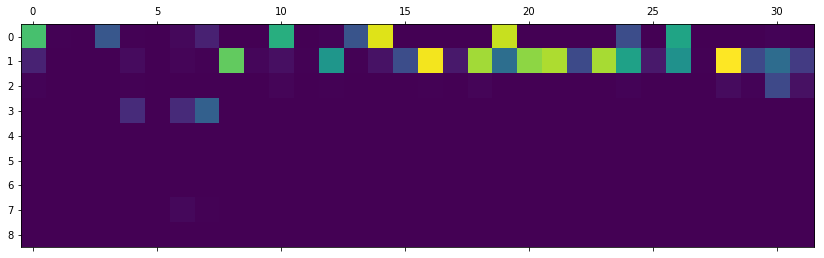

d_loss_real [6.9221685e-05, 1.0]
d_loss_fake [0.00031067396, 1.0]
d_loss_real [0.0004612662, 1.0]
d_loss_fake [0.00013799794, 1.0]
d_loss_real [2.0603391e-05, 1.0]
d_loss_fake [0.00021738815, 1.0]
d_loss_real [7.268508e-05, 1.0]
d_loss_fake [0.00021098547, 1.0]
d_loss_real [0.005724024, 1.0]
d_loss_fake [0.07313928, 0.96875]
d_loss_real [1.4601625e-05, 1.0]
d_loss_fake [0.0014209773, 1.0]
d_loss_real [0.00070853654, 1.0]
d_loss_fake [0.0010518737, 1.0]
d_loss_real [0.049089883, 0.96875]
d_loss_fake [0.0038553055, 1.0]
d_loss_real [0.00027674242, 1.0]
d_loss_fake [0.0006170611, 1.0]
d_loss_real [0.00044335506, 1.0]
d_loss_fake [0.00023481669, 1.0]
d_loss_real [7.0177834e-06, 1.0]
d_loss_fake [0.00020441318, 1.0]
d_loss_real [2.0713582e-05, 1.0]
d_loss_fake [0.00018942688, 1.0]
d_loss_real [0.008532027, 1.0]
d_loss_fake [9.26589e-05, 1.0]
d_loss_real [2.4284468e-06, 1.0]
d_loss_fake [0.00028069178, 1.0]
d_loss_real [3.4330037e-06, 1.0]
d_loss_fake [0.0010566567, 1.0]
d_loss_real [5.26608

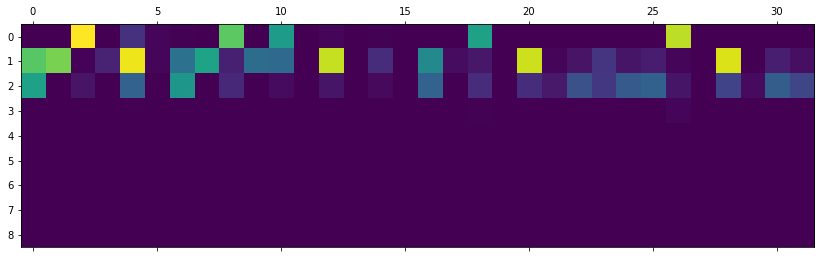

d_loss_real [0.19075248, 0.96875]
d_loss_fake [0.06468525, 0.96875]
d_loss_real [0.01053772, 1.0]
d_loss_fake [0.0056762053, 1.0]
d_loss_real [0.0026139515, 1.0]
d_loss_fake [0.0027564187, 1.0]
d_loss_real [0.016797408, 1.0]
d_loss_fake [0.0013495312, 1.0]
d_loss_real [0.12436223, 0.96875]
d_loss_fake [0.0036041269, 1.0]
d_loss_real [0.00018553564, 1.0]
d_loss_fake [0.102140345, 0.96875]
d_loss_real [0.0024782189, 1.0]
d_loss_fake [0.0037713703, 1.0]
d_loss_real [0.006153849, 1.0]
d_loss_fake [0.0028895491, 1.0]
d_loss_real [0.000339768, 1.0]
d_loss_fake [0.014183192, 1.0]
d_loss_real [0.00082743727, 1.0]
d_loss_fake [0.0011635905, 1.0]
d_loss_real [0.0044566873, 1.0]
d_loss_fake [0.0012662181, 1.0]
d_loss_real [8.0675556e-05, 1.0]
d_loss_fake [0.00062408356, 1.0]
d_loss_real [0.00026851497, 1.0]
d_loss_fake [0.0009703572, 1.0]
d_loss_real [0.0004878127, 1.0]
d_loss_fake [0.0008033281, 1.0]
d_loss_real [0.6143379, 0.875]
d_loss_fake [0.022336636, 1.0]
d_loss_real [0.008273328, 1.0]
d_l

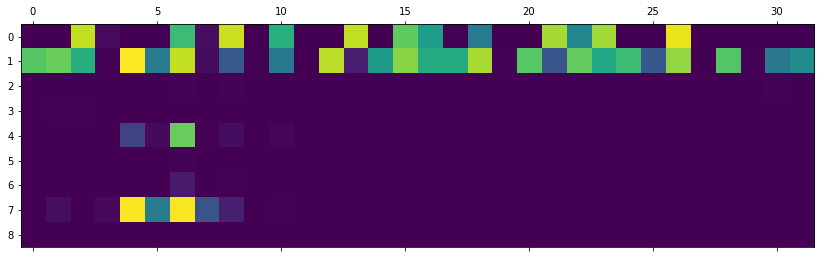

d_loss_real [0.0017990494, 1.0]
d_loss_fake [0.0008987575, 1.0]
d_loss_real [6.872568e-05, 1.0]
d_loss_fake [0.0013343667, 1.0]
d_loss_real [0.000123807, 1.0]
d_loss_fake [0.0018012014, 1.0]
d_loss_real [0.21508649, 0.96875]
d_loss_fake [0.014301328, 1.0]
d_loss_real [0.0010611381, 1.0]
d_loss_fake [0.003533706, 1.0]
d_loss_real [0.0036078906, 1.0]
d_loss_fake [0.007479023, 1.0]
d_loss_real [0.0041629835, 1.0]
d_loss_fake [0.0019413544, 1.0]
d_loss_real [0.0007614173, 1.0]
d_loss_fake [0.0011003254, 1.0]
d_loss_real [0.00013960742, 1.0]
d_loss_fake [0.0021766196, 1.0]
d_loss_real [0.0015590935, 1.0]
d_loss_fake [0.0015959741, 1.0]
d_loss_real [0.08834092, 0.96875]
d_loss_fake [0.09262288, 0.9375]
d_loss_real [0.042166825, 0.96875]
d_loss_fake [0.0038334113, 1.0]
d_loss_real [0.008467269, 1.0]
d_loss_fake [0.0038133368, 1.0]
d_loss_real [0.0001093787, 1.0]
d_loss_fake [0.0311998, 0.96875]
d_loss_real [0.0029915578, 1.0]
d_loss_fake [0.002345826, 1.0]
d_loss_real [0.0023810084, 1.0]
d_lo

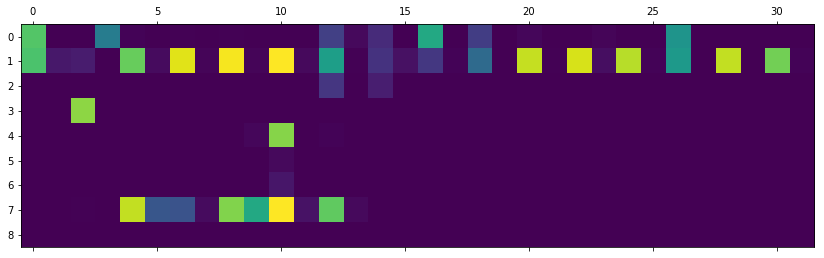

d_loss_real [1.7511932e-06, 1.0]
d_loss_fake [0.00026449503, 1.0]
d_loss_real [0.005465707, 1.0]
d_loss_fake [0.00042055646, 1.0]
d_loss_real [0.00040737406, 1.0]
d_loss_fake [0.0070428015, 1.0]
d_loss_real [5.187888e-06, 1.0]
d_loss_fake [2.5579635e-05, 1.0]
d_loss_real [8.959321e-07, 1.0]
d_loss_fake [2.670462e-05, 1.0]
d_loss_real [0.016230823, 1.0]
d_loss_fake [0.00021627048, 1.0]
d_loss_real [9.718631e-07, 1.0]
d_loss_fake [0.0002156696, 1.0]
d_loss_real [2.5973332e-06, 1.0]
d_loss_fake [5.4850767e-05, 1.0]
d_loss_real [0.004531081, 1.0]
d_loss_fake [0.0075616385, 1.0]
d_loss_real [0.0925143, 0.96875]
d_loss_fake [0.0006358737, 1.0]
d_loss_real [1.5141501e-07, 1.0]
d_loss_fake [0.0008419768, 1.0]
d_loss_real [3.813034e-05, 1.0]
d_loss_fake [0.0028968924, 1.0]
d_loss_real [5.986694e-06, 1.0]
d_loss_fake [0.0002749223, 1.0]
d_loss_real [1.1444751e-07, 1.0]
d_loss_fake [3.577911e-05, 1.0]
d_loss_real [2.0920675e-07, 1.0]
d_loss_fake [0.018599099, 1.0]
d_loss_real [1.8250419e-05, 1.0]

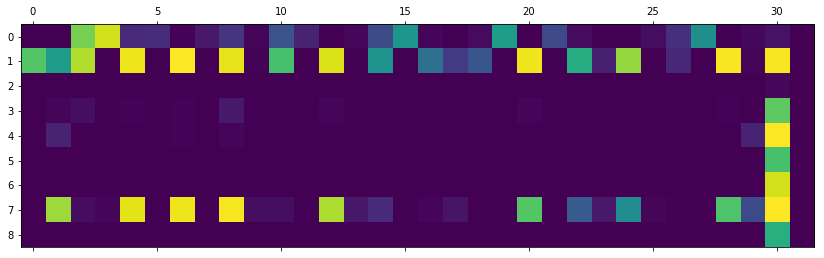

d_loss_real [0.115999036, 0.96875]
d_loss_fake [0.014936011, 1.0]
d_loss_real [0.032585632, 0.96875]
d_loss_fake [0.010701646, 1.0]
d_loss_real [0.009079709, 1.0]
d_loss_fake [0.0106603885, 1.0]
d_loss_real [0.009845819, 1.0]
d_loss_fake [0.0019221097, 1.0]
d_loss_real [0.001364694, 1.0]
d_loss_fake [0.009492654, 1.0]
d_loss_real [0.013888316, 1.0]
d_loss_fake [0.001550584, 1.0]
d_loss_real [5.9957398e-05, 1.0]
d_loss_fake [0.0010978484, 1.0]
d_loss_real [0.0024893542, 1.0]
d_loss_fake [0.004257396, 1.0]
d_loss_real [0.0007020599, 1.0]
d_loss_fake [0.000601016, 1.0]
d_loss_real [0.0006873787, 1.0]
d_loss_fake [0.0006898001, 1.0]
d_loss_real [0.110530205, 0.96875]
d_loss_fake [0.04681293, 0.96875]
d_loss_real [0.00048440316, 1.0]
d_loss_fake [0.0013514564, 1.0]
d_loss_real [0.10005364, 0.96875]
d_loss_fake [0.020940503, 1.0]
d_loss_real [0.050237816, 0.96875]
d_loss_fake [0.446763, 0.8125]
d_loss_real [0.0070869103, 1.0]
d_loss_fake [0.00807467, 1.0]
d_loss_real [0.0048347367, 1.0]
d_lo

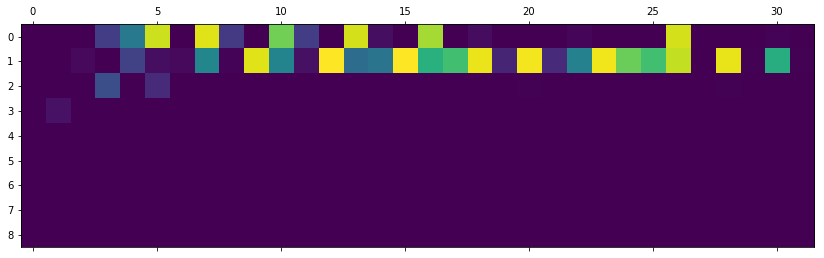

d_loss_real [0.006245213, 1.0]
d_loss_fake [0.0006690913, 1.0]
d_loss_real [0.25692472, 0.9375]
d_loss_fake [0.19359405, 0.90625]
d_loss_real [0.00018061332, 1.0]
d_loss_fake [0.0024628392, 1.0]
d_loss_real [0.17618369, 0.96875]
d_loss_fake [0.010580981, 1.0]
d_loss_real [0.035400704, 0.96875]
d_loss_fake [0.04336842, 0.96875]
d_loss_real [0.13028331, 0.96875]
d_loss_fake [0.11340946, 0.96875]
d_loss_real [0.0040901992, 1.0]
d_loss_fake [0.022763774, 1.0]
d_loss_real [0.0025995255, 1.0]
d_loss_fake [0.0059387004, 1.0]
d_loss_real [0.0011492416, 1.0]
d_loss_fake [0.0136163775, 1.0]
d_loss_real [0.00038889286, 1.0]
d_loss_fake [0.0032485446, 1.0]
d_loss_real [0.0024961298, 1.0]
d_loss_fake [0.0031596138, 1.0]
d_loss_real [0.022108689, 1.0]
d_loss_fake [0.0027225916, 1.0]
d_loss_real [0.0006667743, 1.0]
d_loss_fake [0.0058645583, 1.0]
d_loss_real [2.6117112e-05, 1.0]
d_loss_fake [0.003794836, 1.0]
d_loss_real [0.00017046471, 1.0]
d_loss_fake [0.00097068446, 1.0]
d_loss_real [0.00046006616

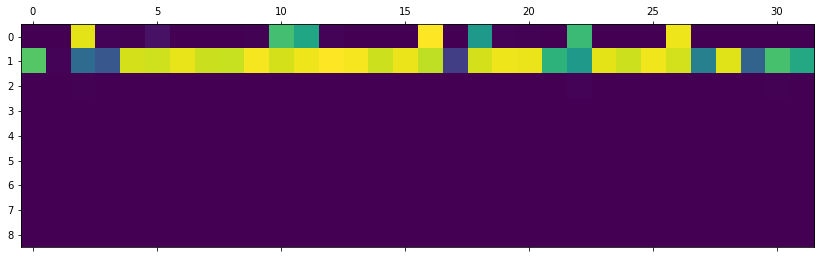

d_loss_real [0.0015280667, 1.0]
d_loss_fake [0.0013082456, 1.0]
d_loss_real [0.06269997, 0.96875]
d_loss_fake [0.0038703296, 1.0]
d_loss_real [0.2140294, 0.96875]
d_loss_fake [0.0035558008, 1.0]
d_loss_real [0.0004620761, 1.0]
d_loss_fake [0.0063534956, 1.0]
d_loss_real [0.0005128079, 1.0]
d_loss_fake [0.0011733342, 1.0]
d_loss_real [2.7561955e-05, 1.0]
d_loss_fake [0.0021522753, 1.0]
d_loss_real [0.001574516, 1.0]
d_loss_fake [0.016909365, 1.0]
d_loss_real [0.0004922246, 1.0]
d_loss_fake [0.0004365042, 1.0]
d_loss_real [3.6716585e-05, 1.0]
d_loss_fake [0.0004999803, 1.0]
d_loss_real [0.016110955, 1.0]
d_loss_fake [0.000485255, 1.0]
d_loss_real [0.0008351445, 1.0]
d_loss_fake [0.00059625285, 1.0]
d_loss_real [0.00045823865, 1.0]
d_loss_fake [0.0004795544, 1.0]
d_loss_real [1.1331324e-05, 1.0]
d_loss_fake [0.00036228567, 1.0]
d_loss_real [0.1362628, 0.96875]
d_loss_fake [0.049811255, 0.96875]
d_loss_real [0.0004172342, 1.0]
d_loss_fake [0.0008338856, 1.0]
d_loss_real [0.0020121844, 1.0]

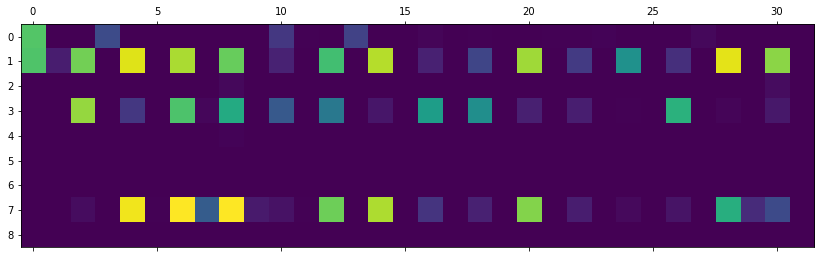

d_loss_real [0.061049078, 0.96875]
d_loss_fake [0.0037836244, 1.0]
d_loss_real [0.09086851, 0.96875]
d_loss_fake [0.01313499, 1.0]
d_loss_real [0.0037135745, 1.0]
d_loss_fake [0.0057778032, 1.0]
d_loss_real [6.448286e-05, 1.0]
d_loss_fake [0.0015395666, 1.0]
d_loss_real [4.4249162e-05, 1.0]
d_loss_fake [0.015169524, 1.0]
d_loss_real [0.0004816288, 1.0]
d_loss_fake [0.0009671353, 1.0]
d_loss_real [0.0008561677, 1.0]
d_loss_fake [0.00055677997, 1.0]
d_loss_real [0.028781833, 0.96875]
d_loss_fake [0.058536287, 0.96875]
d_loss_real [0.028215189, 0.96875]
d_loss_fake [0.0016520492, 1.0]
d_loss_real [3.0218951e-05, 1.0]
d_loss_fake [0.0024833395, 1.0]
d_loss_real [0.00033109487, 1.0]
d_loss_fake [0.0015941333, 1.0]
d_loss_real [0.0010910562, 1.0]
d_loss_fake [0.00023281988, 1.0]
d_loss_real [0.0010341745, 1.0]
d_loss_fake [0.001769257, 1.0]
d_loss_real [0.0008230861, 1.0]
d_loss_fake [0.00028948372, 1.0]
d_loss_real [2.861544e-06, 1.0]
d_loss_fake [0.0009607231, 1.0]
d_loss_real [4.03752e-06

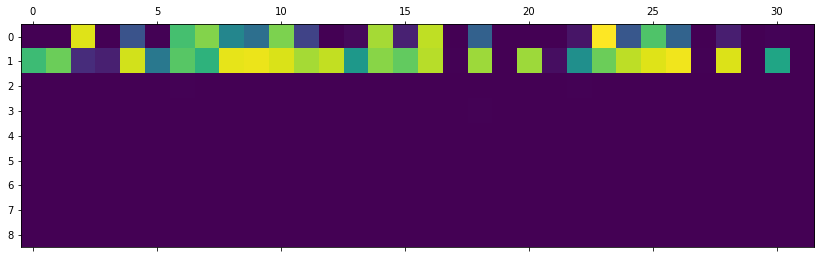

d_loss_real [0.002253054, 1.0]
d_loss_fake [0.00017203654, 1.0]
d_loss_real [0.00039226812, 1.0]
d_loss_fake [0.0005680303, 1.0]
d_loss_real [4.599182e-06, 1.0]
d_loss_fake [0.00045559023, 1.0]
d_loss_real [0.00081976387, 1.0]
d_loss_fake [0.00018325963, 1.0]
d_loss_real [0.09540348, 0.96875]
d_loss_fake [0.0019415661, 1.0]
d_loss_real [0.0002548674, 1.0]
d_loss_fake [0.00072038674, 1.0]
d_loss_real [0.0004634217, 1.0]
d_loss_fake [0.0013722497, 1.0]
d_loss_real [0.050427165, 0.96875]
d_loss_fake [0.023570558, 0.96875]
d_loss_real [0.0028041892, 1.0]
d_loss_fake [0.00065208436, 1.0]
d_loss_real [0.00084412826, 1.0]
d_loss_fake [0.0012689919, 1.0]
d_loss_real [3.364496e-05, 1.0]
d_loss_fake [0.0023877635, 1.0]
d_loss_real [0.21003412, 0.9375]
d_loss_fake [0.0079586, 1.0]
d_loss_real [0.060534723, 0.96875]
d_loss_fake [0.003625477, 1.0]
d_loss_real [6.688306e-05, 1.0]
d_loss_fake [0.012174015, 1.0]
d_loss_real [0.15565278, 0.96875]
d_loss_fake [0.0054317387, 1.0]
d_loss_real [0.001824015

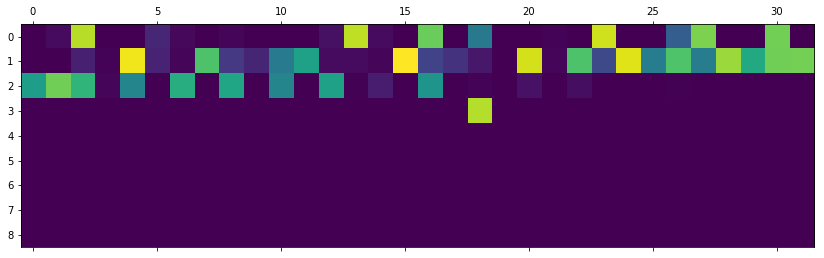

d_loss_real [5.5759287e-05, 1.0]
d_loss_fake [0.00021856949, 1.0]
d_loss_real [0.0041505937, 1.0]
d_loss_fake [0.03304579, 1.0]
d_loss_real [0.00010868153, 1.0]
d_loss_fake [0.00045636517, 1.0]
d_loss_real [3.685902e-05, 1.0]
d_loss_fake [7.520405e-05, 1.0]
d_loss_real [0.004987567, 1.0]
d_loss_fake [0.022759287, 0.96875]
d_loss_real [0.35085115, 0.96875]
d_loss_fake [0.032182753, 1.0]
d_loss_real [7.165512e-05, 1.0]
d_loss_fake [0.00023438611, 1.0]
d_loss_real [0.0015896567, 1.0]
d_loss_fake [0.0002706125, 1.0]
d_loss_real [0.021806141, 0.96875]
d_loss_fake [0.00036251656, 1.0]
d_loss_real [3.7667345e-05, 1.0]
d_loss_fake [0.0005372495, 1.0]
d_loss_real [0.00011430547, 1.0]
d_loss_fake [0.00457828, 1.0]
d_loss_real [0.19016874, 0.96875]
d_loss_fake [0.0031048232, 1.0]
d_loss_real [0.020854156, 1.0]
d_loss_fake [0.17295094, 0.96875]
d_loss_real [0.00037269515, 1.0]
d_loss_fake [0.0032314756, 1.0]
d_loss_real [0.00055009837, 1.0]
d_loss_fake [0.0023827848, 1.0]
d_loss_real [0.021501053,

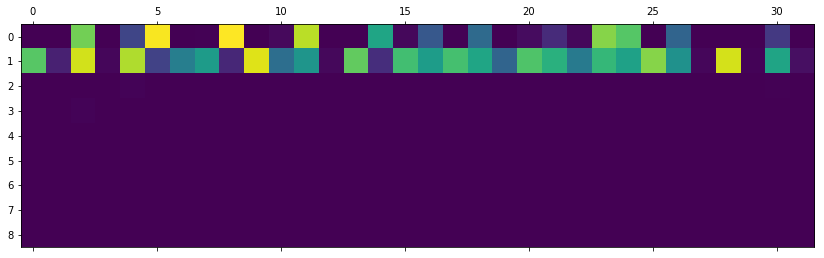

d_loss_real [0.00050973904, 1.0]
d_loss_fake [0.007947781, 1.0]
d_loss_real [0.030429507, 1.0]
d_loss_fake [0.0007986693, 1.0]
d_loss_real [0.05300399, 0.96875]
d_loss_fake [0.011415, 1.0]
d_loss_real [0.0014822009, 1.0]
d_loss_fake [0.00057573256, 1.0]
d_loss_real [0.00010928654, 1.0]
d_loss_fake [0.001817856, 1.0]
d_loss_real [0.12943366, 0.96875]
d_loss_fake [0.010070912, 1.0]
d_loss_real [0.043841716, 0.96875]
d_loss_fake [0.10698329, 0.96875]
d_loss_real [0.0019447592, 1.0]
d_loss_fake [0.021656834, 1.0]
d_loss_real [0.002070694, 1.0]
d_loss_fake [0.004951922, 1.0]
d_loss_real [0.0033159084, 1.0]
d_loss_fake [0.0011670459, 1.0]
d_loss_real [0.14432675, 0.96875]
d_loss_fake [0.007697816, 1.0]
d_loss_real [0.01962501, 1.0]
d_loss_fake [0.015225211, 1.0]
d_loss_real [0.00013981701, 1.0]
d_loss_fake [0.0022480893, 1.0]
d_loss_real [0.000280266, 1.0]
d_loss_fake [0.025760576, 1.0]
d_loss_real [0.0023695068, 1.0]
d_loss_fake [0.019885605, 1.0]
d_loss_real [6.3777756e-05, 1.0]
d_loss_fak

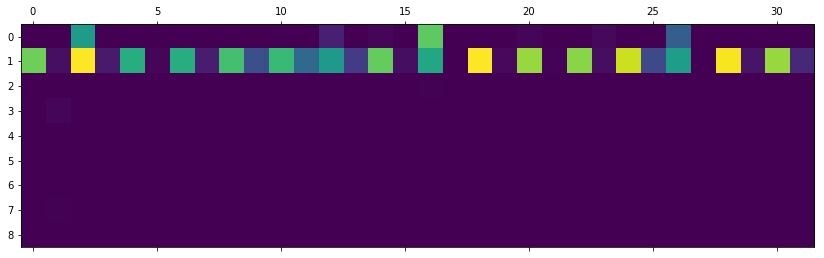

d_loss_real [0.0018413697, 1.0]
d_loss_fake [0.003918943, 1.0]
d_loss_real [0.2660432, 0.9375]
d_loss_fake [0.016434692, 1.0]
d_loss_real [0.0029807573, 1.0]
d_loss_fake [0.030313704, 1.0]
d_loss_real [0.0019476127, 1.0]
d_loss_fake [0.0038893223, 1.0]
d_loss_real [0.0023112376, 1.0]
d_loss_fake [0.0032692407, 1.0]
d_loss_real [0.00010747538, 1.0]
d_loss_fake [0.0029522753, 1.0]
d_loss_real [0.006568119, 1.0]
d_loss_fake [0.002605081, 1.0]
d_loss_real [0.013704878, 1.0]
d_loss_fake [0.019718971, 1.0]
d_loss_real [0.00015289625, 1.0]
d_loss_fake [0.0006089009, 1.0]
d_loss_real [0.0010946156, 1.0]
d_loss_fake [0.00048252402, 1.0]
d_loss_real [2.9092902e-05, 1.0]
d_loss_fake [0.002195462, 1.0]
d_loss_real [0.00011509661, 1.0]
d_loss_fake [0.0003773836, 1.0]
d_loss_real [0.00055711693, 1.0]
d_loss_fake [0.00046545174, 1.0]
d_loss_real [6.449243e-05, 1.0]
d_loss_fake [0.0004037844, 1.0]
d_loss_real [1.25425195e-05, 1.0]
d_loss_fake [0.00031026982, 1.0]
d_loss_real [2.6228417e-05, 1.0]
d_los

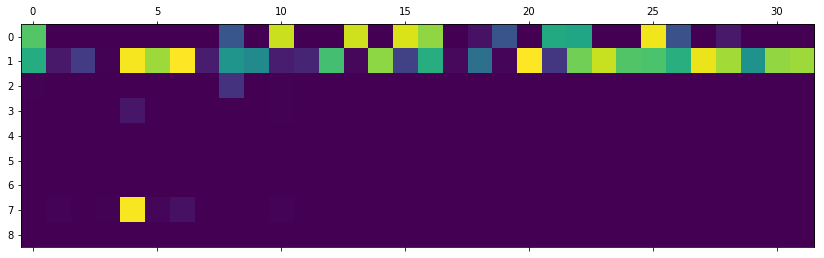

d_loss_real [0.07364405, 0.96875]
d_loss_fake [0.12799062, 0.96875]
d_loss_real [0.06166829, 0.96875]
d_loss_fake [0.081962354, 0.96875]
d_loss_real [0.0009264379, 1.0]
d_loss_fake [0.023728997, 1.0]
d_loss_real [0.00032316102, 1.0]
d_loss_fake [0.028678814, 0.96875]
d_loss_real [0.010533478, 1.0]
d_loss_fake [0.0017911711, 1.0]
d_loss_real [0.0004008973, 1.0]
d_loss_fake [0.0010344835, 1.0]
d_loss_real [0.022271445, 0.96875]
d_loss_fake [0.0016538836, 1.0]
d_loss_real [1.4097245e-05, 1.0]
d_loss_fake [0.0035993566, 1.0]
d_loss_real [0.07809795, 0.96875]
d_loss_fake [0.0033680354, 1.0]
d_loss_real [0.0007064757, 1.0]
d_loss_fake [0.05421288, 0.96875]
d_loss_real [0.00021795733, 1.0]
d_loss_fake [0.009814276, 1.0]
d_loss_real [0.0029015408, 1.0]
d_loss_fake [0.0039654947, 1.0]
d_loss_real [0.0005538226, 1.0]
d_loss_fake [0.0011938282, 1.0]
d_loss_real [0.0021940055, 1.0]
d_loss_fake [0.0033233946, 1.0]
d_loss_real [9.031572e-06, 1.0]
d_loss_fake [0.008225682, 1.0]
d_loss_real [3.5064036

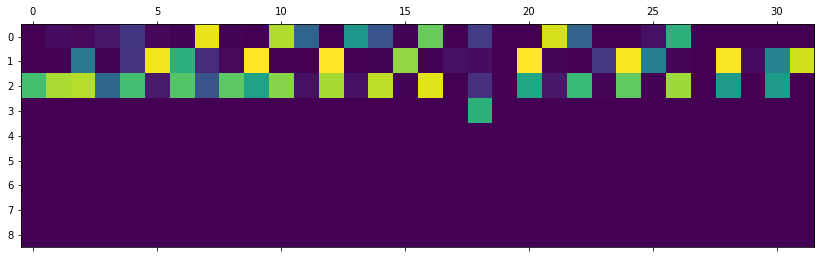

d_loss_real [0.0036156331, 1.0]
d_loss_fake [0.0077880006, 1.0]
d_loss_real [0.0036721174, 1.0]
d_loss_fake [0.003104196, 1.0]
d_loss_real [0.0026632985, 1.0]
d_loss_fake [0.003034267, 1.0]
d_loss_real [0.0011328305, 1.0]
d_loss_fake [0.0025593205, 1.0]
d_loss_real [0.0022784357, 1.0]
d_loss_fake [0.0036056947, 1.0]
d_loss_real [7.168271e-05, 1.0]
d_loss_fake [0.0010515099, 1.0]
d_loss_real [0.0006993792, 1.0]
d_loss_fake [0.00080434536, 1.0]
d_loss_real [0.0039039617, 1.0]
d_loss_fake [0.0028546022, 1.0]
d_loss_real [0.00044649196, 1.0]
d_loss_fake [0.1613462, 0.96875]
d_loss_real [0.00070959434, 1.0]
d_loss_fake [0.0010238006, 1.0]
d_loss_real [0.18817395, 0.96875]
d_loss_fake [0.012495023, 1.0]
d_loss_real [0.0015702472, 1.0]
d_loss_fake [0.0070854286, 1.0]
d_loss_real [0.0068394607, 1.0]
d_loss_fake [0.0016585325, 1.0]
d_loss_real [0.00026717174, 1.0]
d_loss_fake [0.0013422959, 1.0]
d_loss_real [0.0009121294, 1.0]
d_loss_fake [0.0022351486, 1.0]
d_loss_real [0.0018604319, 1.0]
d_lo

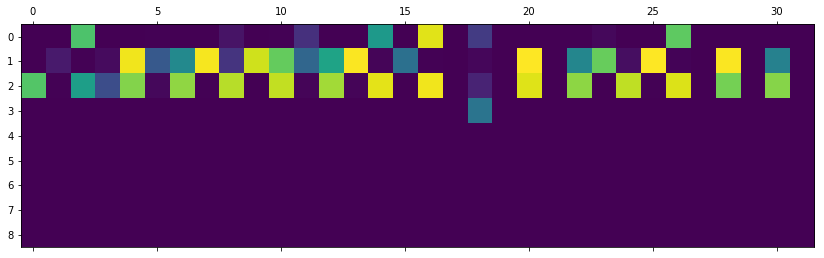

d_loss_real [0.0029553592, 1.0]
d_loss_fake [0.0018433309, 1.0]
d_loss_real [0.00026607822, 1.0]
d_loss_fake [0.0035883475, 1.0]
d_loss_real [5.9917656e-05, 1.0]
d_loss_fake [0.0008956107, 1.0]
d_loss_real [9.4808616e-05, 1.0]
d_loss_fake [0.013946314, 1.0]
d_loss_real [0.000110054956, 1.0]
d_loss_fake [0.00052409613, 1.0]
d_loss_real [0.00037983013, 1.0]
d_loss_fake [0.0006586999, 1.0]
d_loss_real [0.06414052, 0.96875]
d_loss_fake [0.034386277, 1.0]
d_loss_real [0.00807501, 1.0]
d_loss_fake [0.0010443476, 1.0]
d_loss_real [6.98449e-05, 1.0]
d_loss_fake [0.00028711936, 1.0]
d_loss_real [0.025885189, 0.96875]
d_loss_fake [0.00033288222, 1.0]
d_loss_real [8.6469816e-05, 1.0]
d_loss_fake [0.00030053037, 1.0]
d_loss_real [6.945649e-05, 1.0]
d_loss_fake [0.026460106, 0.96875]
d_loss_real [0.005749841, 1.0]
d_loss_fake [0.0016258389, 1.0]
d_loss_real [0.115497455, 0.96875]
d_loss_fake [0.17149147, 0.90625]
d_loss_real [0.100173235, 0.96875]
d_loss_fake [0.014472708, 1.0]
d_loss_real [0.00096

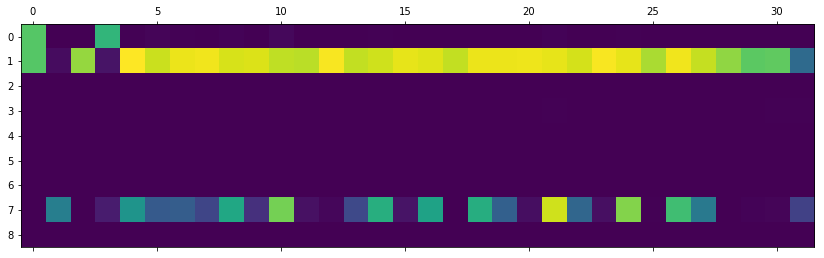

d_loss_real [0.0010393804, 1.0]
d_loss_fake [0.0007404699, 1.0]
d_loss_real [9.3776136e-05, 1.0]
d_loss_fake [0.0028403928, 1.0]
d_loss_real [0.00018832699, 1.0]
d_loss_fake [0.000379306, 1.0]
d_loss_real [7.2014496e-05, 1.0]
d_loss_fake [0.0011206581, 1.0]
d_loss_real [0.00010831076, 1.0]
d_loss_fake [0.00045365735, 1.0]
d_loss_real [0.15927814, 0.96875]
d_loss_fake [0.021091785, 1.0]
d_loss_real [0.0024224517, 1.0]
d_loss_fake [0.017071826, 1.0]
d_loss_real [0.005770469, 1.0]
d_loss_fake [0.005116634, 1.0]
d_loss_real [0.22822179, 0.96875]
d_loss_fake [0.050635725, 0.96875]
d_loss_real [0.04187777, 0.96875]
d_loss_fake [0.020605955, 1.0]
d_loss_real [0.00761168, 1.0]
d_loss_fake [0.0057544466, 1.0]
d_loss_real [0.002681508, 1.0]
d_loss_fake [0.0023865297, 1.0]
d_loss_real [2.2437267e-05, 1.0]
d_loss_fake [0.001518141, 1.0]
d_loss_real [0.055089068, 0.96875]
d_loss_fake [0.13932687, 0.90625]
d_loss_real [0.00027002677, 1.0]
d_loss_fake [0.0046790997, 1.0]
d_loss_real [0.00027026125, 1

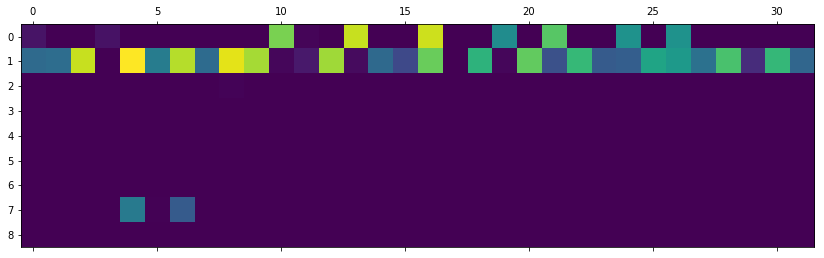

d_loss_real [0.015745664, 1.0]
d_loss_fake [0.09753599, 0.9375]
d_loss_real [0.0046634185, 1.0]
d_loss_fake [0.0018642582, 1.0]
d_loss_real [0.08247336, 0.96875]
d_loss_fake [0.0015578785, 1.0]
d_loss_real [0.010771783, 1.0]
d_loss_fake [0.0009669864, 1.0]
d_loss_real [0.22378528, 0.9375]
d_loss_fake [0.14663962, 0.96875]
d_loss_real [0.04429947, 0.96875]
d_loss_fake [0.005795427, 1.0]
d_loss_real [0.0014075277, 1.0]
d_loss_fake [0.050378673, 0.96875]
d_loss_real [0.007879626, 1.0]
d_loss_fake [0.003310563, 1.0]
d_loss_real [0.00066675426, 1.0]
d_loss_fake [0.0022713062, 1.0]
d_loss_real [0.03219908, 0.96875]
d_loss_fake [0.0019097514, 1.0]
d_loss_real [8.1866805e-05, 1.0]
d_loss_fake [0.105063885, 0.96875]
d_loss_real [0.048323616, 0.96875]
d_loss_fake [0.004154014, 1.0]
d_loss_real [0.0025483537, 1.0]
d_loss_fake [0.011341629, 1.0]
d_loss_real [0.0064270427, 1.0]
d_loss_fake [0.0009699064, 1.0]
d_loss_real [0.00014526327, 1.0]
d_loss_fake [0.0010447878, 1.0]
d_loss_real [0.01463628, 

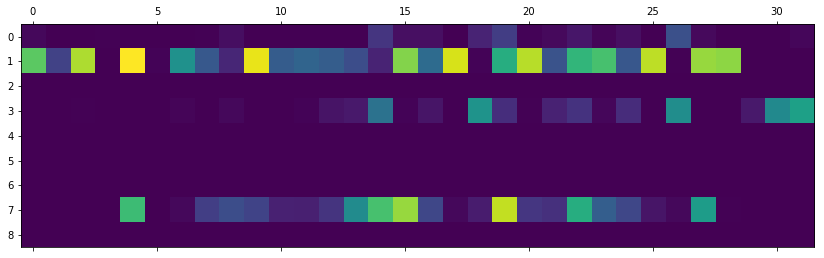

d_loss_real [0.122853085, 0.96875]
d_loss_fake [0.0038191702, 1.0]
d_loss_real [0.1270959, 0.96875]
d_loss_fake [0.015634958, 1.0]
d_loss_real [0.02333316, 0.96875]
d_loss_fake [0.006413566, 1.0]
d_loss_real [0.05206937, 0.96875]
d_loss_fake [0.014134635, 1.0]
d_loss_real [0.00020155004, 1.0]
d_loss_fake [0.00758761, 1.0]
d_loss_real [0.06869407, 0.96875]
d_loss_fake [0.042309437, 0.96875]
d_loss_real [0.00042119034, 1.0]
d_loss_fake [0.004964884, 1.0]
d_loss_real [0.05622978, 0.96875]
d_loss_fake [0.0076146442, 1.0]
d_loss_real [0.0007247255, 1.0]
d_loss_fake [0.0013113897, 1.0]
d_loss_real [0.31838605, 0.96875]
d_loss_fake [0.011044305, 1.0]
d_loss_real [0.19586632, 0.96875]
d_loss_fake [0.011289945, 1.0]
d_loss_real [0.011466113, 1.0]
d_loss_fake [0.037462786, 0.96875]
d_loss_real [0.007824023, 1.0]
d_loss_fake [0.033313517, 0.96875]
d_loss_real [0.048224688, 0.96875]
d_loss_fake [0.13854584, 0.96875]
d_loss_real [0.017057259, 1.0]
d_loss_fake [0.030500568, 1.0]
d_loss_real [0.00453

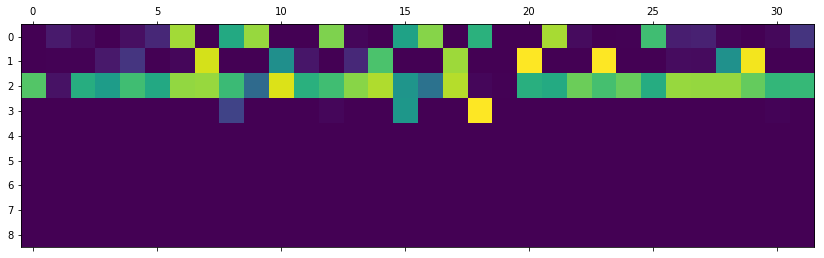

d_loss_real [0.023227138, 1.0]
d_loss_fake [0.0033003662, 1.0]
d_loss_real [0.08070323, 0.96875]
d_loss_fake [0.009250505, 1.0]
d_loss_real [0.0015212728, 1.0]
d_loss_fake [0.011300323, 1.0]
d_loss_real [0.0007039785, 1.0]
d_loss_fake [0.005748205, 1.0]
d_loss_real [0.0005942824, 1.0]
d_loss_fake [0.00085820723, 1.0]
d_loss_real [0.00024133053, 1.0]
d_loss_fake [0.0016948608, 1.0]
d_loss_real [0.00040139086, 1.0]
d_loss_fake [0.0066566505, 1.0]
d_loss_real [8.620889e-05, 1.0]
d_loss_fake [0.0008029919, 1.0]
d_loss_real [0.4846134, 0.90625]
d_loss_fake [0.010784272, 1.0]
d_loss_real [0.0038864054, 1.0]
d_loss_fake [0.006681622, 1.0]
d_loss_real [0.029602386, 0.96875]
d_loss_fake [0.013408815, 1.0]
d_loss_real [0.00058946107, 1.0]
d_loss_fake [0.0056177825, 1.0]
d_loss_real [0.000470932, 1.0]
d_loss_fake [0.010227836, 1.0]
d_loss_real [0.0006172047, 1.0]
d_loss_fake [0.0017734906, 1.0]
d_loss_real [0.00020614939, 1.0]
d_loss_fake [0.002534952, 1.0]
d_loss_real [0.101653025, 0.96875]
d_lo

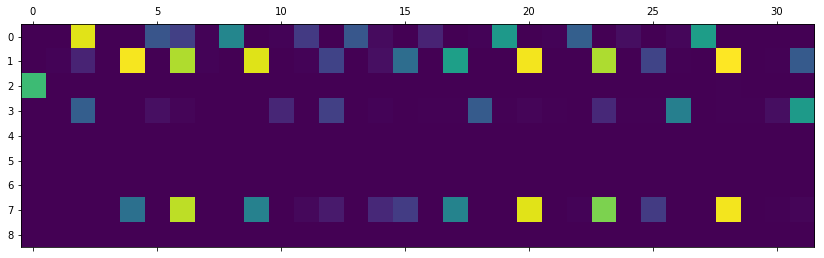

d_loss_real [0.0032741604, 1.0]
d_loss_fake [0.00039961174, 1.0]
d_loss_real [0.00043732586, 1.0]
d_loss_fake [0.00051972136, 1.0]
d_loss_real [0.06661613, 0.96875]
d_loss_fake [0.011502079, 1.0]
d_loss_real [0.313354, 0.96875]
d_loss_fake [0.02071452, 1.0]
d_loss_real [0.001121238, 1.0]
d_loss_fake [0.006906884, 1.0]
d_loss_real [0.00039902396, 1.0]
d_loss_fake [0.0024817, 1.0]
d_loss_real [0.00022944079, 1.0]
d_loss_fake [0.00089562056, 1.0]
d_loss_real [0.0038122255, 1.0]
d_loss_fake [0.0036148746, 1.0]
d_loss_real [5.938589e-05, 1.0]
d_loss_fake [0.00067683693, 1.0]
d_loss_real [0.00022971017, 1.0]
d_loss_fake [0.0010710054, 1.0]
d_loss_real [0.0038887623, 1.0]
d_loss_fake [0.00043597454, 1.0]
d_loss_real [0.007782935, 1.0]
d_loss_fake [0.00067389023, 1.0]
d_loss_real [0.16405648, 0.96875]
d_loss_fake [0.0039115036, 1.0]
d_loss_real [0.12171149, 0.96875]
d_loss_fake [0.007293168, 1.0]
d_loss_real [9.695506e-05, 1.0]
d_loss_fake [0.09469089, 0.96875]
d_loss_real [0.00028718595, 1.0]

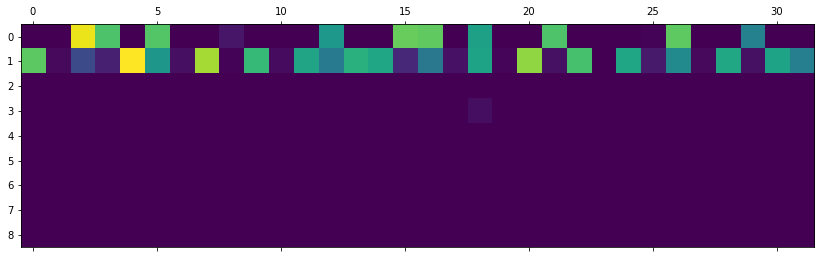

d_loss_real [0.0003400505, 1.0]
d_loss_fake [0.006291869, 1.0]
d_loss_real [0.08266042, 0.96875]
d_loss_fake [0.06973137, 0.96875]
d_loss_real [0.021795865, 1.0]
d_loss_fake [0.09556387, 0.96875]
d_loss_real [0.0282547, 0.96875]
d_loss_fake [0.003395678, 1.0]
d_loss_real [0.03518531, 1.0]
d_loss_fake [0.14031677, 0.9375]
d_loss_real [0.0025624328, 1.0]
d_loss_fake [0.0038352564, 1.0]
d_loss_real [0.00217812, 1.0]
d_loss_fake [0.030993609, 0.96875]
d_loss_real [0.001318564, 1.0]
d_loss_fake [0.0061691785, 1.0]
d_loss_real [0.0003243439, 1.0]
d_loss_fake [0.0020764875, 1.0]
d_loss_real [0.00017956417, 1.0]
d_loss_fake [0.0014562954, 1.0]
d_loss_real [0.2328511, 0.96875]
d_loss_fake [0.026114061, 1.0]
d_loss_real [0.0012126924, 1.0]
d_loss_fake [0.007342209, 1.0]
d_loss_real [0.00057058537, 1.0]
d_loss_fake [0.0040945066, 1.0]
d_loss_real [0.00019992719, 1.0]
d_loss_fake [0.0030929109, 1.0]
d_loss_real [0.06683432, 0.96875]
d_loss_fake [0.20066188, 0.875]
d_loss_real [0.12212103, 0.96875]

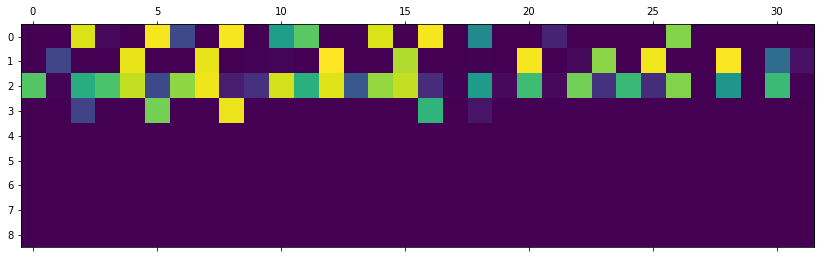

d_loss_real [0.00019665936, 1.0]
d_loss_fake [0.0041261287, 1.0]
d_loss_real [0.0071187154, 1.0]
d_loss_fake [0.01668236, 1.0]
d_loss_real [0.124788366, 0.96875]
d_loss_fake [0.1454701, 0.875]
d_loss_real [0.0120642055, 1.0]
d_loss_fake [0.11641526, 0.9375]
d_loss_real [0.10822585, 0.96875]
d_loss_fake [0.026607053, 1.0]
d_loss_real [0.0018083174, 1.0]
d_loss_fake [0.004142955, 1.0]
d_loss_real [0.0033956952, 1.0]
d_loss_fake [0.0031143667, 1.0]
d_loss_real [0.0010634854, 1.0]
d_loss_fake [0.016248958, 1.0]
d_loss_real [0.12328441, 0.9375]
d_loss_fake [0.00943911, 1.0]
d_loss_real [0.0012618469, 1.0]
d_loss_fake [0.016596757, 1.0]
d_loss_real [0.26408446, 0.90625]
d_loss_fake [0.070434466, 0.96875]
d_loss_real [0.024877103, 1.0]
d_loss_fake [0.006189809, 1.0]
d_loss_real [0.0022712348, 1.0]
d_loss_fake [0.013295897, 1.0]
d_loss_real [0.00049395004, 1.0]
d_loss_fake [0.0051497887, 1.0]
d_loss_real [0.0005100843, 1.0]
d_loss_fake [0.0018312649, 1.0]
d_loss_real [0.0009897184, 1.0]
d_loss

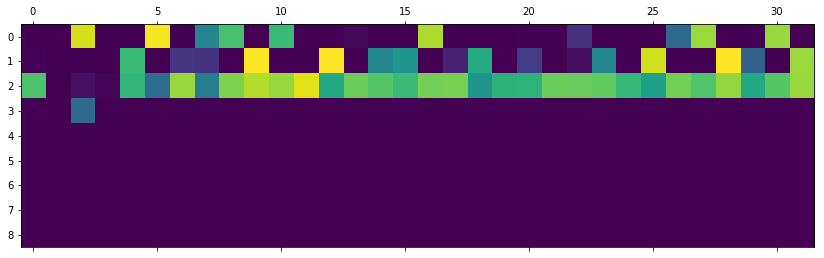

d_loss_real [0.17195722, 0.96875]
d_loss_fake [0.008685978, 1.0]
d_loss_real [0.0002517264, 1.0]
d_loss_fake [0.009561276, 1.0]
d_loss_real [0.00029562355, 1.0]
d_loss_fake [0.0056194942, 1.0]
d_loss_real [0.030856283, 0.96875]
d_loss_fake [0.056465324, 0.96875]
d_loss_real [0.0005817042, 1.0]
d_loss_fake [0.0023515576, 1.0]
d_loss_real [0.0013795048, 1.0]
d_loss_fake [0.005340787, 1.0]
d_loss_real [0.0071518235, 1.0]
d_loss_fake [0.0012791486, 1.0]
d_loss_real [0.0007075184, 1.0]
d_loss_fake [0.000832463, 1.0]
d_loss_real [0.034545187, 0.96875]
d_loss_fake [0.002964999, 1.0]
d_loss_real [6.0400136e-05, 1.0]
d_loss_fake [0.0005974162, 1.0]
d_loss_real [0.0022136688, 1.0]
d_loss_fake [0.000406397, 1.0]
d_loss_real [7.1974873e-06, 1.0]
d_loss_fake [0.00051552255, 1.0]
d_loss_real [0.0008475986, 1.0]
d_loss_fake [0.0014848446, 1.0]
d_loss_real [0.00023534495, 1.0]
d_loss_fake [0.0009939532, 1.0]
d_loss_real [4.7375343e-06, 1.0]
d_loss_fake [0.0024942223, 1.0]
d_loss_real [0.033737063, 0.9

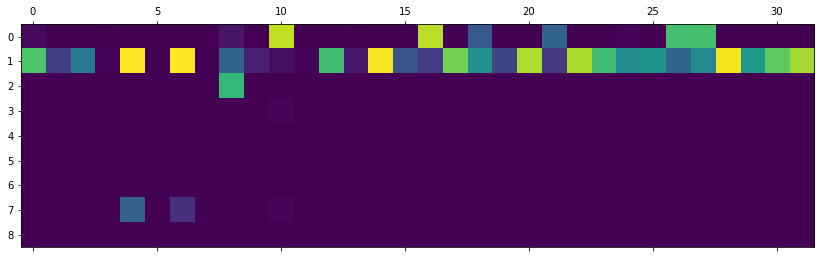

d_loss_real [0.005281318, 1.0]
d_loss_fake [0.0017547339, 1.0]
d_loss_real [6.7547546e-05, 1.0]
d_loss_fake [0.20153563, 0.9375]
d_loss_real [0.12184078, 0.96875]
d_loss_fake [0.0076024765, 1.0]
d_loss_real [0.0016586008, 1.0]
d_loss_fake [0.0033452213, 1.0]
d_loss_real [0.0052546435, 1.0]
d_loss_fake [0.0031617028, 1.0]
d_loss_real [0.14691857, 0.96875]
d_loss_fake [0.0108211655, 1.0]
d_loss_real [0.07284712, 0.96875]
d_loss_fake [0.022094307, 1.0]
d_loss_real [0.1957991, 0.96875]
d_loss_fake [0.09194827, 0.96875]
d_loss_real [0.000855525, 1.0]
d_loss_fake [0.007039348, 1.0]
d_loss_real [0.07914853, 0.96875]
d_loss_fake [0.036386494, 1.0]
d_loss_real [0.08011753, 0.96875]
d_loss_fake [0.08127511, 0.96875]
d_loss_real [0.0004950068, 1.0]
d_loss_fake [0.004768154, 1.0]
d_loss_real [0.0007565147, 1.0]
d_loss_fake [0.014119497, 1.0]
d_loss_real [0.0022354512, 1.0]
d_loss_fake [0.0019039512, 1.0]
d_loss_real [0.104588605, 0.9375]
d_loss_fake [0.0037254645, 1.0]
d_loss_real [0.0983977, 0.96

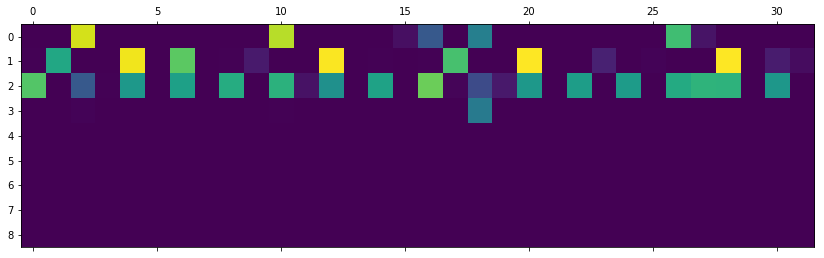

d_loss_real [0.00027033762, 1.0]
d_loss_fake [0.012671006, 1.0]
d_loss_real [0.00012238814, 1.0]
d_loss_fake [0.0075080204, 1.0]
d_loss_real [0.0044521103, 1.0]
d_loss_fake [0.0008648909, 1.0]
d_loss_real [0.008598676, 1.0]
d_loss_fake [0.00085734995, 1.0]
d_loss_real [6.0832903e-05, 1.0]
d_loss_fake [0.012116249, 1.0]
d_loss_real [6.268175e-05, 1.0]
d_loss_fake [0.00082278275, 1.0]
d_loss_real [0.00012473701, 1.0]
d_loss_fake [0.0005958012, 1.0]
d_loss_real [0.010202633, 1.0]
d_loss_fake [0.0039453143, 1.0]
d_loss_real [5.6144894e-05, 1.0]
d_loss_fake [0.0003492532, 1.0]
d_loss_real [4.6955833e-05, 1.0]
d_loss_fake [0.00077056105, 1.0]
d_loss_real [0.00017256412, 1.0]
d_loss_fake [0.00035897316, 1.0]
d_loss_real [2.614716e-06, 1.0]
d_loss_fake [0.00025390036, 1.0]
d_loss_real [0.00010967772, 1.0]
d_loss_fake [0.005142304, 1.0]
d_loss_real [7.5122335e-07, 1.0]
d_loss_fake [0.0001927798, 1.0]
d_loss_real [0.003022016, 1.0]
d_loss_fake [0.0019636485, 1.0]
d_loss_real [0.00027339673, 1.0]

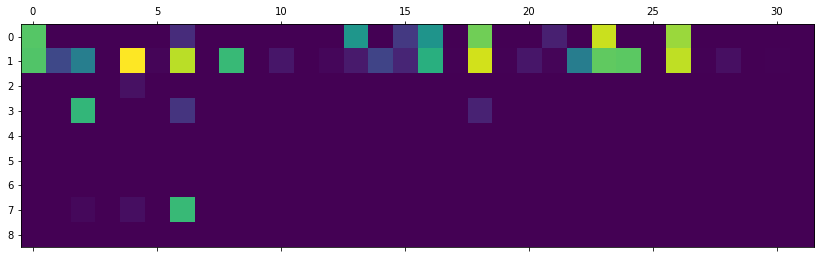

d_loss_real [0.11653585, 0.96875]
d_loss_fake [0.0033808048, 1.0]
d_loss_real [0.00028851203, 1.0]
d_loss_fake [0.0070467535, 1.0]
d_loss_real [2.7254377e-05, 1.0]
d_loss_fake [0.0012646823, 1.0]
d_loss_real [0.00020248788, 1.0]
d_loss_fake [0.0011248058, 1.0]
d_loss_real [0.0002399774, 1.0]
d_loss_fake [0.051351137, 0.96875]
d_loss_real [0.0013437793, 1.0]
d_loss_fake [0.0010326758, 1.0]
d_loss_real [0.0010880389, 1.0]
d_loss_fake [0.0013030749, 1.0]
d_loss_real [0.0006130975, 1.0]
d_loss_fake [0.005480081, 1.0]
d_loss_real [0.00036266024, 1.0]
d_loss_fake [0.0004291044, 1.0]
d_loss_real [0.000120207376, 1.0]
d_loss_fake [0.00031608492, 1.0]
d_loss_real [0.00044798164, 1.0]
d_loss_fake [0.00031211897, 1.0]
d_loss_real [0.0010454062, 1.0]
d_loss_fake [0.00020720669, 1.0]
d_loss_real [2.7904123e-05, 1.0]
d_loss_fake [0.00030179636, 1.0]
d_loss_real [9.590912e-05, 1.0]
d_loss_fake [0.00018037338, 1.0]
d_loss_real [8.576442e-05, 1.0]
d_loss_fake [0.0002603941, 1.0]
d_loss_real [1.9554933e

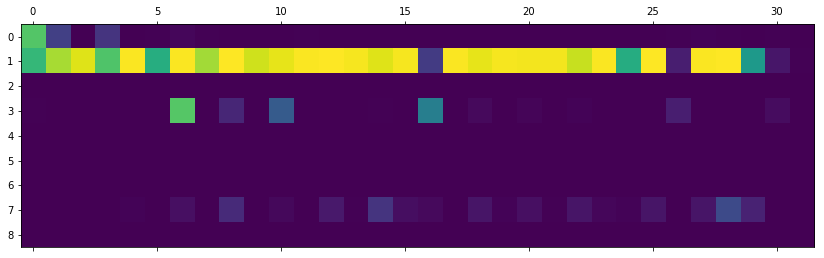

d_loss_real [0.00045185082, 1.0]
d_loss_fake [0.016154476, 1.0]
d_loss_real [0.0017530413, 1.0]
d_loss_fake [0.0016748777, 1.0]
d_loss_real [0.39892465, 0.9375]
d_loss_fake [0.016841147, 1.0]
d_loss_real [0.00037553464, 1.0]
d_loss_fake [0.0073229703, 1.0]
d_loss_real [0.000944304, 1.0]
d_loss_fake [0.0056815725, 1.0]
d_loss_real [0.00022324154, 1.0]
d_loss_fake [0.0026057526, 1.0]
d_loss_real [0.019723916, 1.0]
d_loss_fake [0.0028436282, 1.0]
d_loss_real [0.00010135541, 1.0]
d_loss_fake [0.0028333534, 1.0]
d_loss_real [0.00025392583, 1.0]
d_loss_fake [0.0034928347, 1.0]
d_loss_real [0.0004915241, 1.0]
d_loss_fake [0.016057732, 1.0]
d_loss_real [0.000100952646, 1.0]
d_loss_fake [0.001428551, 1.0]
d_loss_real [0.00016810282, 1.0]
d_loss_fake [0.0009189393, 1.0]
d_loss_real [0.00022131062, 1.0]
d_loss_fake [0.0041590678, 1.0]
d_loss_real [0.058927163, 0.96875]
d_loss_fake [0.17137657, 0.9375]
d_loss_real [0.0004545731, 1.0]
d_loss_fake [0.0031871288, 1.0]
d_loss_real [0.00046650693, 1.0]

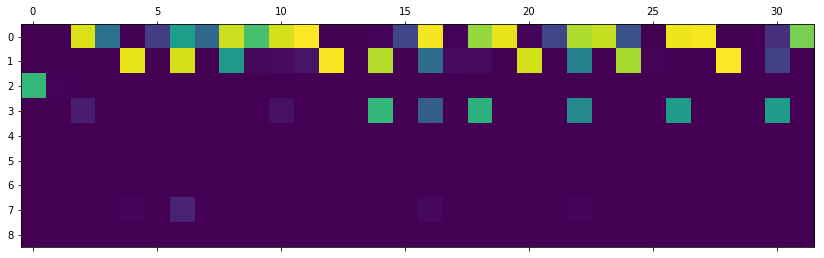

d_loss_real [0.0025250146, 1.0]
d_loss_fake [0.0021422096, 1.0]
d_loss_real [0.00010579828, 1.0]
d_loss_fake [0.0005556855, 1.0]
d_loss_real [0.026414398, 0.96875]
d_loss_fake [0.002040621, 1.0]
d_loss_real [0.00032597053, 1.0]
d_loss_fake [0.18451643, 0.96875]
d_loss_real [0.24261078, 0.96875]
d_loss_fake [0.0070420913, 1.0]
d_loss_real [0.0039363354, 1.0]
d_loss_fake [0.005218741, 1.0]
d_loss_real [0.09034126, 0.96875]
d_loss_fake [0.026394473, 1.0]
d_loss_real [0.0005079008, 1.0]
d_loss_fake [0.004950433, 1.0]
d_loss_real [0.0075798137, 1.0]
d_loss_fake [0.03192469, 1.0]
d_loss_real [0.0005571902, 1.0]
d_loss_fake [0.0013524292, 1.0]
d_loss_real [5.2503852e-05, 1.0]
d_loss_fake [0.0018857036, 1.0]
d_loss_real [6.599665e-05, 1.0]
d_loss_fake [0.0008918462, 1.0]
d_loss_real [0.17788391, 0.9375]
d_loss_fake [0.015947994, 1.0]
d_loss_real [0.040945925, 0.96875]
d_loss_fake [0.009213883, 1.0]
d_loss_real [2.0854404e-05, 1.0]
d_loss_fake [0.0040246584, 1.0]
d_loss_real [0.00031608547, 1.0

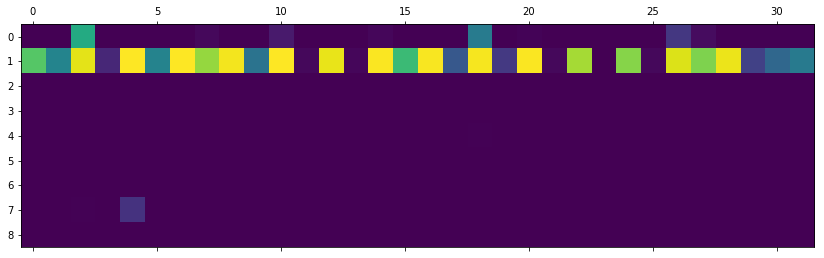

d_loss_real [0.0016732395, 1.0]
d_loss_fake [0.001935167, 1.0]
d_loss_real [0.0013564483, 1.0]
d_loss_fake [0.00080607994, 1.0]
d_loss_real [0.0038388663, 1.0]
d_loss_fake [0.0034736507, 1.0]
d_loss_real [0.00074514205, 1.0]
d_loss_fake [0.010641436, 1.0]
d_loss_real [0.0006862071, 1.0]
d_loss_fake [0.00030032243, 1.0]
d_loss_real [0.00034653532, 1.0]
d_loss_fake [0.00022455129, 1.0]
d_loss_real [0.0007023499, 1.0]
d_loss_fake [0.00018753938, 1.0]
d_loss_real [0.22354822, 0.96875]
d_loss_fake [0.0066505237, 1.0]
d_loss_real [0.00014585158, 1.0]
d_loss_fake [0.0030049598, 1.0]
d_loss_real [0.00069002825, 1.0]
d_loss_fake [0.0009772974, 1.0]
d_loss_real [0.00023808161, 1.0]
d_loss_fake [0.0006003505, 1.0]
d_loss_real [0.073071264, 0.96875]
d_loss_fake [0.004521811, 1.0]
d_loss_real [8.9595545e-05, 1.0]
d_loss_fake [0.0056271283, 1.0]
d_loss_real [0.00050882285, 1.0]
d_loss_fake [0.0007610493, 1.0]
d_loss_real [9.565699e-06, 1.0]
d_loss_fake [0.0021262933, 1.0]
d_loss_real [3.839256e-05, 

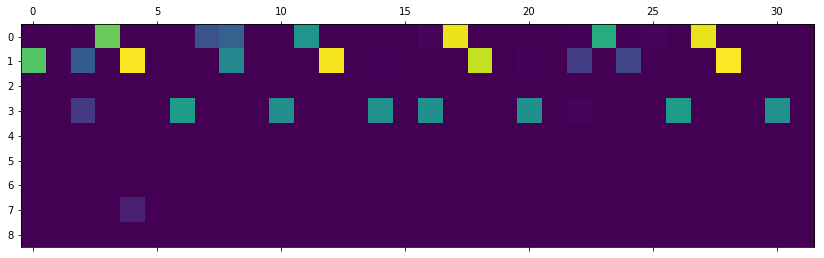

d_loss_real [0.001873349, 1.0]
d_loss_fake [0.0007299984, 1.0]
d_loss_real [5.852695e-05, 1.0]
d_loss_fake [0.013402196, 1.0]
d_loss_real [4.827717e-05, 1.0]
d_loss_fake [0.009687431, 1.0]
d_loss_real [0.00020079462, 1.0]
d_loss_fake [0.0005235868, 1.0]
d_loss_real [0.17082801, 0.96875]
d_loss_fake [0.058473147, 1.0]
d_loss_real [0.0019420835, 1.0]
d_loss_fake [0.0056480933, 1.0]
d_loss_real [0.0008737921, 1.0]
d_loss_fake [0.0010621089, 1.0]
d_loss_real [0.0788559, 0.96875]
d_loss_fake [0.11137272, 0.96875]
d_loss_real [0.00068284525, 1.0]
d_loss_fake [0.010440383, 1.0]
d_loss_real [0.11112793, 0.96875]
d_loss_fake [0.016174752, 1.0]
d_loss_real [0.15809782, 0.96875]
d_loss_fake [0.013894955, 1.0]
d_loss_real [0.003347961, 1.0]
d_loss_fake [0.0063194986, 1.0]
d_loss_real [0.00019077757, 1.0]
d_loss_fake [0.0058025797, 1.0]
d_loss_real [0.00043450488, 1.0]
d_loss_fake [0.0038406397, 1.0]
d_loss_real [0.00027967006, 1.0]
d_loss_fake [0.0019646059, 1.0]
d_loss_real [0.00036880258, 1.0]
d

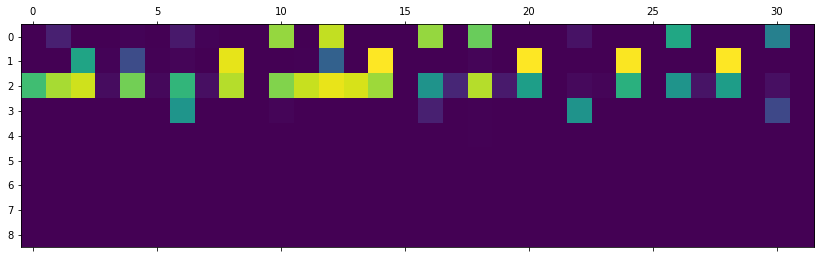

d_loss_real [0.00013335228, 1.0]
d_loss_fake [0.00145645, 1.0]
d_loss_real [0.0012010307, 1.0]
d_loss_fake [0.00078963744, 1.0]
d_loss_real [0.00033233583, 1.0]
d_loss_fake [0.004280169, 1.0]
d_loss_real [0.08634254, 0.96875]
d_loss_fake [0.0022594382, 1.0]
d_loss_real [0.0005195497, 1.0]
d_loss_fake [0.002374588, 1.0]
d_loss_real [0.022313785, 0.96875]
d_loss_fake [0.0007145123, 1.0]
d_loss_real [0.013569603, 1.0]
d_loss_fake [0.003256576, 1.0]
d_loss_real [1.8513616e-05, 1.0]
d_loss_fake [0.0023643726, 1.0]
d_loss_real [0.00032109654, 1.0]
d_loss_fake [0.0051463777, 1.0]
d_loss_real [1.3053328e-05, 1.0]
d_loss_fake [0.005601652, 1.0]
d_loss_real [3.0464594e-06, 1.0]
d_loss_fake [0.0012459069, 1.0]
d_loss_real [2.8015385e-05, 1.0]
d_loss_fake [0.0015053211, 1.0]
d_loss_real [0.0007968035, 1.0]
d_loss_fake [0.000523266, 1.0]
d_loss_real [0.30277714, 0.96875]
d_loss_fake [0.007532198, 1.0]
d_loss_real [0.04404553, 0.96875]
d_loss_fake [0.0023128865, 1.0]
d_loss_real [0.00017899189, 1.0]

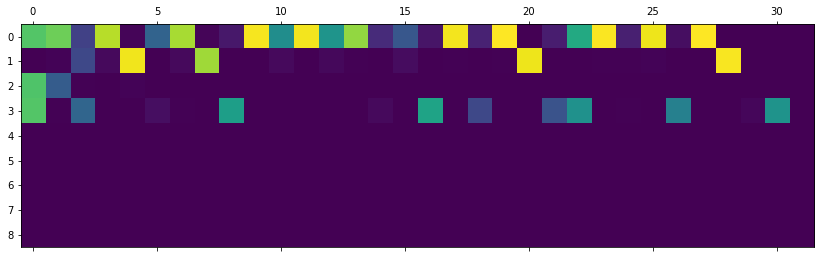

d_loss_real [0.15429635, 0.96875]
d_loss_fake [0.009010248, 1.0]
d_loss_real [0.00027574788, 1.0]
d_loss_fake [0.105085656, 0.96875]
d_loss_real [0.0007645488, 1.0]
d_loss_fake [0.007874546, 1.0]
d_loss_real [0.0009252311, 1.0]
d_loss_fake [0.050210226, 0.96875]
d_loss_real [0.0026040934, 1.0]
d_loss_fake [0.009792007, 1.0]
d_loss_real [0.00032250775, 1.0]
d_loss_fake [0.0017682073, 1.0]
d_loss_real [0.097717226, 0.96875]
d_loss_fake [0.060689487, 0.96875]
d_loss_real [0.2032159, 0.9375]
d_loss_fake [0.022363303, 1.0]
d_loss_real [0.00079600076, 1.0]
d_loss_fake [0.006495607, 1.0]
d_loss_real [0.0073953196, 1.0]
d_loss_fake [0.0036429341, 1.0]
d_loss_real [0.0004383472, 1.0]
d_loss_fake [0.006289932, 1.0]
d_loss_real [0.0004978562, 1.0]
d_loss_fake [0.024551349, 0.96875]
d_loss_real [0.00017953085, 1.0]
d_loss_fake [0.0058064656, 1.0]
d_loss_real [0.00015503948, 1.0]
d_loss_fake [0.0014811156, 1.0]
d_loss_real [0.0004904783, 1.0]
d_loss_fake [0.0012740262, 1.0]
d_loss_real [0.002752973

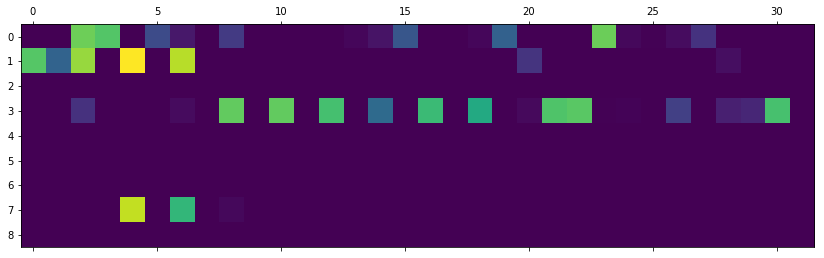

d_loss_real [0.00010635679, 1.0]
d_loss_fake [0.0019691573, 1.0]
d_loss_real [1.9153224e-05, 1.0]
d_loss_fake [0.0051054303, 1.0]
d_loss_real [9.67685e-06, 1.0]
d_loss_fake [0.19613795, 0.96875]
d_loss_real [0.0009851882, 1.0]
d_loss_fake [0.025818937, 0.96875]
d_loss_real [0.0017214685, 1.0]
d_loss_fake [0.0062895515, 1.0]
d_loss_real [0.0069604535, 1.0]
d_loss_fake [0.002832526, 1.0]
d_loss_real [0.00015154932, 1.0]
d_loss_fake [0.0019916934, 1.0]
d_loss_real [0.028787911, 0.96875]
d_loss_fake [0.0015588966, 1.0]
d_loss_real [7.063716e-05, 1.0]
d_loss_fake [0.0033021097, 1.0]
d_loss_real [0.08547629, 0.96875]
d_loss_fake [0.0020026679, 1.0]
d_loss_real [0.0017072257, 1.0]
d_loss_fake [0.052676506, 0.96875]
d_loss_real [0.1677528, 0.96875]
d_loss_fake [0.0048699407, 1.0]
d_loss_real [0.00039213325, 1.0]
d_loss_fake [0.0038730102, 1.0]
d_loss_real [0.00029412672, 1.0]
d_loss_fake [0.0033356852, 1.0]
d_loss_real [0.0020367387, 1.0]
d_loss_fake [0.0023316431, 1.0]
d_loss_real [0.00012214

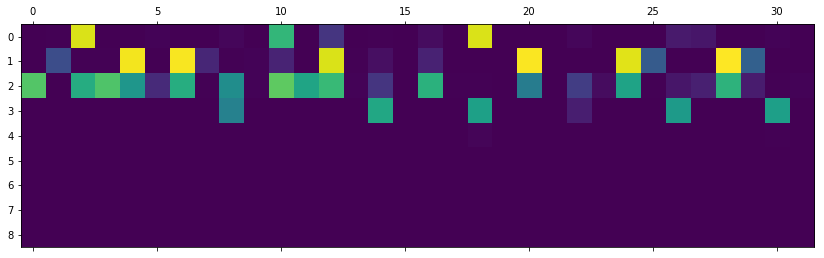

d_loss_real [0.050349787, 0.96875]
d_loss_fake [0.050858043, 0.96875]
d_loss_real [0.0005272262, 1.0]
d_loss_fake [0.007135634, 1.0]
d_loss_real [0.00012367702, 1.0]
d_loss_fake [0.0038849302, 1.0]
d_loss_real [0.00036039186, 1.0]
d_loss_fake [0.0039165914, 1.0]
d_loss_real [0.004127659, 1.0]
d_loss_fake [0.004669542, 1.0]
d_loss_real [0.10872863, 0.96875]
d_loss_fake [0.007091316, 1.0]
d_loss_real [0.0069865175, 1.0]
d_loss_fake [0.009434175, 1.0]
d_loss_real [0.00049579144, 1.0]
d_loss_fake [0.0069135097, 1.0]
d_loss_real [0.00034739127, 1.0]
d_loss_fake [0.001841554, 1.0]
d_loss_real [0.004989098, 1.0]
d_loss_fake [0.00067238684, 1.0]
d_loss_real [0.000128246, 1.0]
d_loss_fake [0.0016855211, 1.0]
d_loss_real [0.0001331258, 1.0]
d_loss_fake [0.0006239526, 1.0]
d_loss_real [4.490612e-05, 1.0]
d_loss_fake [0.0041102557, 1.0]
d_loss_real [0.20676267, 0.96875]
d_loss_fake [0.020155549, 1.0]
d_loss_real [0.012362768, 1.0]
d_loss_fake [0.007515317, 1.0]
d_loss_real [2.827257e-05, 1.0]
d_lo

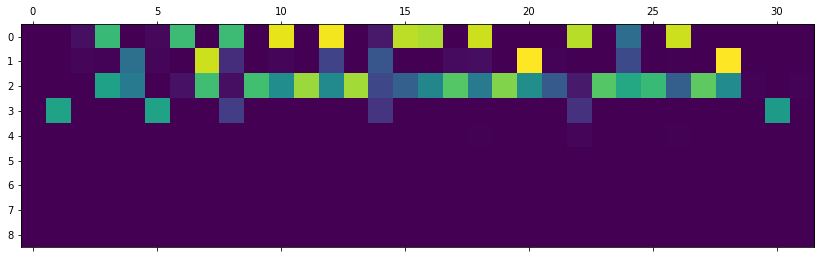

d_loss_real [2.570502e-05, 1.0]
d_loss_fake [0.0009934495, 1.0]
d_loss_real [5.694714e-06, 1.0]
d_loss_fake [0.0005050144, 1.0]
d_loss_real [0.14719392, 0.96875]
d_loss_fake [0.012539291, 1.0]
d_loss_real [6.775087e-05, 1.0]
d_loss_fake [0.0024919957, 1.0]
d_loss_real [0.0008968361, 1.0]
d_loss_fake [0.0031275996, 1.0]
d_loss_real [0.0010295291, 1.0]
d_loss_fake [0.0017568324, 1.0]
d_loss_real [5.300294e-06, 1.0]
d_loss_fake [0.0050846045, 1.0]
d_loss_real [0.0004429204, 1.0]
d_loss_fake [0.004497117, 1.0]
d_loss_real [0.22703302, 0.9375]
d_loss_fake [0.0092997905, 1.0]
d_loss_real [0.04181427, 0.96875]
d_loss_fake [0.063375354, 0.96875]
d_loss_real [0.21523756, 0.96875]
d_loss_fake [0.022277879, 1.0]
d_loss_real [7.40197e-05, 1.0]
d_loss_fake [0.05307031, 1.0]
d_loss_real [0.0010003338, 1.0]
d_loss_fake [0.00582437, 1.0]
d_loss_real [3.5773803e-05, 1.0]
d_loss_fake [0.0016374767, 1.0]
d_loss_real [5.1689512e-05, 1.0]
d_loss_fake [0.0014524171, 1.0]
d_loss_real [9.624482e-05, 1.0]
d_lo

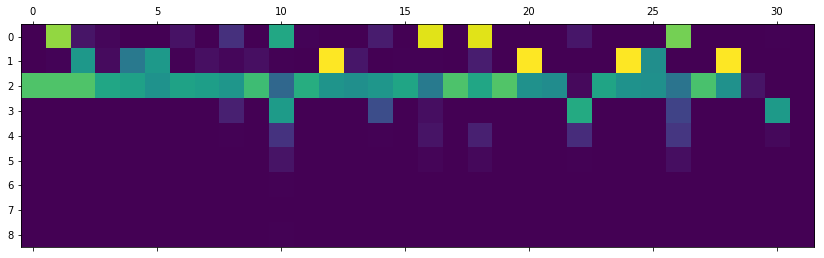

d_loss_real [0.00012148431, 1.0]
d_loss_fake [0.0025284581, 1.0]
d_loss_real [0.09989543, 0.96875]
d_loss_fake [0.0019199341, 1.0]
d_loss_real [2.1496387e-05, 1.0]
d_loss_fake [0.0013268499, 1.0]
d_loss_real [2.1431706e-05, 1.0]
d_loss_fake [0.002873509, 1.0]
d_loss_real [6.770379e-05, 1.0]
d_loss_fake [0.010784865, 1.0]
d_loss_real [1.1596549e-05, 1.0]
d_loss_fake [0.0006006224, 1.0]
d_loss_real [0.08135582, 0.96875]
d_loss_fake [0.032022633, 0.96875]
d_loss_real [0.00033396346, 1.0]
d_loss_fake [0.00157329, 1.0]
d_loss_real [0.0008581902, 1.0]
d_loss_fake [0.003037858, 1.0]
d_loss_real [0.00027103908, 1.0]
d_loss_fake [0.0022449296, 1.0]
d_loss_real [0.00014470535, 1.0]
d_loss_fake [0.0005520887, 1.0]
d_loss_real [0.0033736476, 1.0]
d_loss_fake [0.00028612095, 1.0]
d_loss_real [3.810191e-05, 1.0]
d_loss_fake [0.00080862746, 1.0]
d_loss_real [4.240035e-06, 1.0]
d_loss_fake [0.005049061, 1.0]
d_loss_real [8.67623e-06, 1.0]
d_loss_fake [0.00047390768, 1.0]
d_loss_real [0.017858595, 1.0]

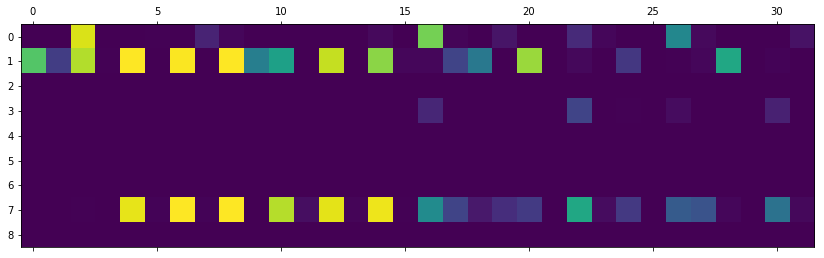

d_loss_real [1.2247612e-05, 1.0]
d_loss_fake [0.00090586033, 1.0]
d_loss_real [5.9696707e-05, 1.0]
d_loss_fake [0.00041370938, 1.0]
d_loss_real [5.419609e-06, 1.0]
d_loss_fake [0.010065555, 1.0]
d_loss_real [0.084116705, 0.96875]
d_loss_fake [0.012196005, 1.0]
d_loss_real [0.04946679, 0.96875]
d_loss_fake [0.015617012, 1.0]
d_loss_real [0.00017030956, 1.0]
d_loss_fake [0.011211051, 1.0]
d_loss_real [0.20992821, 0.96875]
d_loss_fake [0.0035708423, 1.0]
d_loss_real [4.6022808e-05, 1.0]
d_loss_fake [0.019963942, 1.0]
d_loss_real [0.0041114725, 1.0]
d_loss_fake [0.00082933565, 1.0]
d_loss_real [0.010714713, 1.0]
d_loss_fake [0.0016198468, 1.0]
d_loss_real [0.0037167654, 1.0]
d_loss_fake [0.0023486116, 1.0]
d_loss_real [0.014534843, 1.0]
d_loss_fake [0.0015617189, 1.0]
d_loss_real [3.0807917e-06, 1.0]
d_loss_fake [0.0008536728, 1.0]
d_loss_real [0.009700319, 1.0]
d_loss_fake [0.0016542417, 1.0]
d_loss_real [0.0002087788, 1.0]
d_loss_fake [0.033906616, 0.96875]
d_loss_real [0.00040771306, 1.

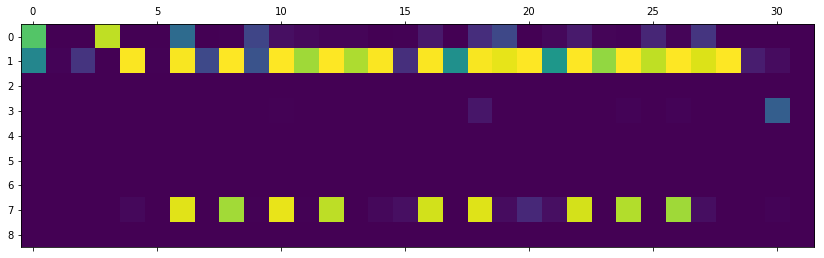

d_loss_real [0.00016275667, 1.0]
d_loss_fake [0.00036595884, 1.0]
d_loss_real [3.4261186e-05, 1.0]
d_loss_fake [0.00066308794, 1.0]
d_loss_real [2.2708746e-06, 1.0]
d_loss_fake [0.027315972, 0.96875]
d_loss_real [2.1874469e-06, 1.0]
d_loss_fake [0.0002616663, 1.0]
d_loss_real [0.0014435976, 1.0]
d_loss_fake [0.00010121978, 1.0]
d_loss_real [6.4920896e-06, 1.0]
d_loss_fake [0.00022921475, 1.0]
d_loss_real [0.23725696, 0.96875]
d_loss_fake [0.0020196051, 1.0]
d_loss_real [0.00013325534, 1.0]
d_loss_fake [0.0015916033, 1.0]
d_loss_real [1.6122896e-05, 1.0]
d_loss_fake [0.0023292887, 1.0]
d_loss_real [0.024074374, 1.0]
d_loss_fake [0.13524975, 0.90625]
d_loss_real [0.11094142, 0.96875]
d_loss_fake [0.007060593, 1.0]
d_loss_real [0.0028961643, 1.0]
d_loss_fake [0.0024273607, 1.0]
d_loss_real [0.00063879526, 1.0]
d_loss_fake [0.0023493771, 1.0]
d_loss_real [0.0031978826, 1.0]
d_loss_fake [0.032680765, 0.96875]
d_loss_real [0.015939506, 1.0]
d_loss_fake [0.0024308458, 1.0]
d_loss_real [0.0002

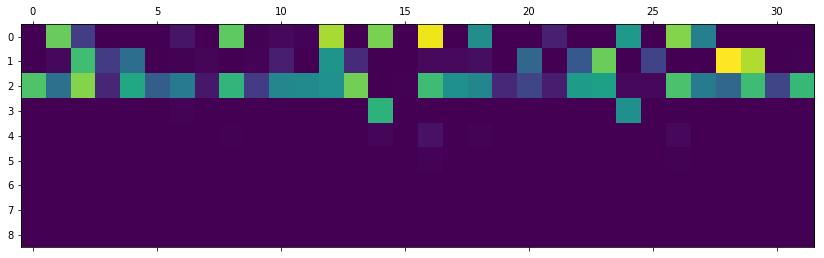

d_loss_real [0.052349847, 0.96875]
d_loss_fake [0.002339168, 1.0]
d_loss_real [1.6440013e-06, 1.0]
d_loss_fake [0.002454135, 1.0]
d_loss_real [8.124837e-07, 1.0]
d_loss_fake [0.0007773929, 1.0]
d_loss_real [0.053527895, 0.96875]
d_loss_fake [0.0015215233, 1.0]
d_loss_real [1.0366309e-06, 1.0]
d_loss_fake [0.08334886, 0.96875]
d_loss_real [0.007091935, 1.0]
d_loss_fake [0.0013444868, 1.0]
d_loss_real [0.00047835856, 1.0]
d_loss_fake [0.00056523544, 1.0]
d_loss_real [1.8389695e-05, 1.0]
d_loss_fake [0.0012312329, 1.0]
d_loss_real [0.008840644, 1.0]
d_loss_fake [0.00065855565, 1.0]
d_loss_real [1.03925595e-05, 1.0]
d_loss_fake [0.0012579537, 1.0]
d_loss_real [0.00013566161, 1.0]
d_loss_fake [0.00090204796, 1.0]
d_loss_real [0.00036541262, 1.0]
d_loss_fake [0.00037538577, 1.0]
d_loss_real [0.22811423, 0.96875]
d_loss_fake [0.009448928, 1.0]
d_loss_real [0.00035093073, 1.0]
d_loss_fake [0.03493051, 0.96875]
d_loss_real [0.013343345, 1.0]
d_loss_fake [0.011808729, 1.0]
d_loss_real [1.774304e

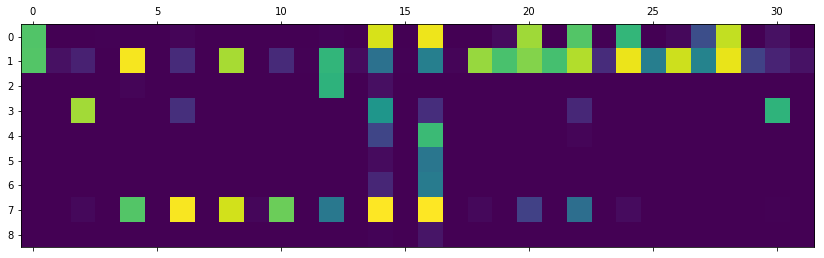

d_loss_real [0.0002106866, 1.0]
d_loss_fake [0.0034861704, 1.0]
d_loss_real [0.0004936356, 1.0]
d_loss_fake [0.011149357, 1.0]
d_loss_real [0.0003045459, 1.0]
d_loss_fake [0.0014602458, 1.0]
d_loss_real [0.0004185976, 1.0]
d_loss_fake [0.0007866639, 1.0]
d_loss_real [0.01406914, 1.0]
d_loss_fake [0.06900529, 0.96875]
d_loss_real [0.0005879042, 1.0]
d_loss_fake [0.0020120675, 1.0]
d_loss_real [0.09596916, 0.96875]
d_loss_fake [0.0025118361, 1.0]
d_loss_real [0.0014934028, 1.0]
d_loss_fake [0.0023391051, 1.0]
d_loss_real [0.17936622, 0.96875]
d_loss_fake [0.11527379, 0.96875]
d_loss_real [0.017229715, 1.0]
d_loss_fake [0.04583276, 0.96875]
d_loss_real [0.02873485, 0.96875]
d_loss_fake [0.0041439068, 1.0]
d_loss_real [0.0007851053, 1.0]
d_loss_fake [0.0022252626, 1.0]
d_loss_real [0.0037268298, 1.0]
d_loss_fake [0.0013025947, 1.0]
d_loss_real [0.0003557353, 1.0]
d_loss_fake [0.002884007, 1.0]
d_loss_real [0.026702844, 0.96875]
d_loss_fake [0.0017988461, 1.0]
d_loss_real [0.06364596, 0.968

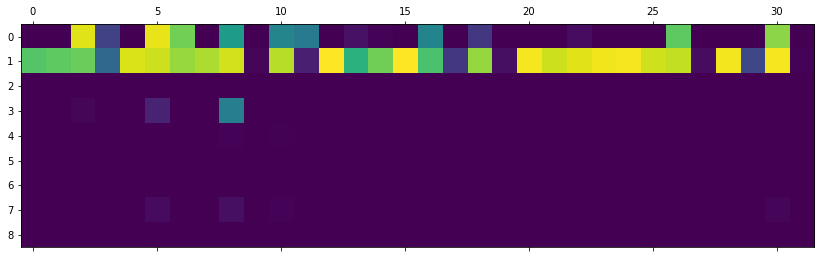

d_loss_real [0.001578396, 1.0]
d_loss_fake [0.0018023811, 1.0]
d_loss_real [0.06728501, 0.96875]
d_loss_fake [0.0032823705, 1.0]
d_loss_real [0.09456937, 0.96875]
d_loss_fake [0.051404547, 0.96875]
d_loss_real [0.013704795, 1.0]
d_loss_fake [0.0033325064, 1.0]
d_loss_real [0.0010248193, 1.0]
d_loss_fake [0.0031714402, 1.0]
d_loss_real [0.002206049, 1.0]
d_loss_fake [0.001191257, 1.0]
d_loss_real [0.0006812192, 1.0]
d_loss_fake [0.0057321796, 1.0]
d_loss_real [0.020885931, 1.0]
d_loss_fake [0.0013445822, 1.0]
d_loss_real [1.0757494e-05, 1.0]
d_loss_fake [0.0028220322, 1.0]
d_loss_real [1.3190814e-05, 1.0]
d_loss_fake [0.0017496194, 1.0]
d_loss_real [6.605098e-05, 1.0]
d_loss_fake [0.0006836031, 1.0]
d_loss_real [8.177129e-06, 1.0]
d_loss_fake [0.00045193953, 1.0]
d_loss_real [0.0020641827, 1.0]
d_loss_fake [0.0016892969, 1.0]
d_loss_real [0.40259898, 0.9375]
d_loss_fake [0.018035602, 1.0]
d_loss_real [0.019396536, 1.0]
d_loss_fake [0.0056597376, 1.0]
d_loss_real [0.00011928957, 1.0]
d_l

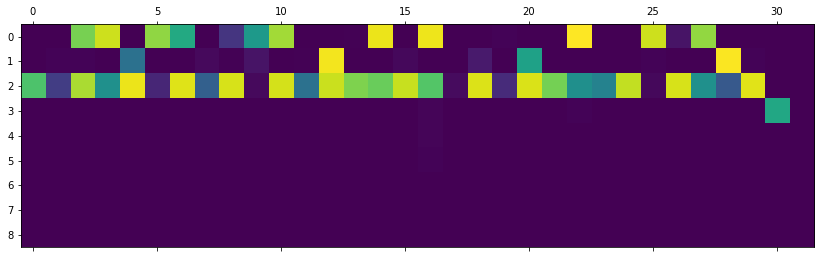

d_loss_real [5.6077515e-05, 1.0]
d_loss_fake [0.007669828, 1.0]
d_loss_real [0.07361256, 0.96875]
d_loss_fake [0.058777623, 0.96875]
d_loss_real [0.021605778, 1.0]
d_loss_fake [0.058400758, 0.96875]
d_loss_real [0.007652219, 1.0]
d_loss_fake [0.003621504, 1.0]
d_loss_real [0.000999858, 1.0]
d_loss_fake [0.03248259, 0.96875]
d_loss_real [4.0420877e-05, 1.0]
d_loss_fake [0.0008334636, 1.0]
d_loss_real [0.0012953628, 1.0]
d_loss_fake [0.015766576, 1.0]
d_loss_real [0.0018315887, 1.0]
d_loss_fake [0.037801646, 0.96875]
d_loss_real [0.0006188733, 1.0]
d_loss_fake [0.0005755847, 1.0]
d_loss_real [4.162248e-05, 1.0]
d_loss_fake [0.00027692565, 1.0]
d_loss_real [0.20174114, 0.9375]
d_loss_fake [0.041897353, 0.96875]
d_loss_real [0.0030850584, 1.0]
d_loss_fake [0.0035104053, 1.0]
d_loss_real [0.0004355858, 1.0]
d_loss_fake [0.0023580086, 1.0]
d_loss_real [0.0005783383, 1.0]
d_loss_fake [0.0015949167, 1.0]
d_loss_real [0.063544296, 0.96875]
d_loss_fake [0.00075817807, 1.0]
d_loss_real [0.0001038

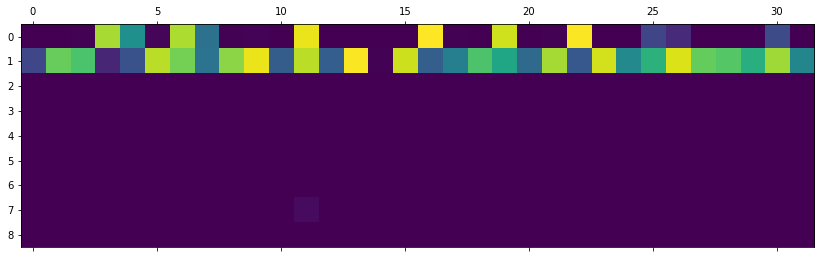

d_loss_real [0.00034445303, 1.0]
d_loss_fake [0.00069361227, 1.0]
d_loss_real [9.030565e-05, 1.0]
d_loss_fake [0.0007809845, 1.0]
d_loss_real [0.16539463, 0.96875]
d_loss_fake [0.03652952, 1.0]
d_loss_real [0.0006396506, 1.0]
d_loss_fake [0.015606105, 1.0]
d_loss_real [0.0011076867, 1.0]
d_loss_fake [0.0061886217, 1.0]
d_loss_real [0.0016069312, 1.0]
d_loss_fake [0.004024425, 1.0]
d_loss_real [0.0007781349, 1.0]
d_loss_fake [0.00044976472, 1.0]
d_loss_real [0.0004151375, 1.0]
d_loss_fake [0.002205262, 1.0]


In [ ]:

batch_size = 32
nb_epochs = 300
nb_samples = matrices_drums.shape[0]

K_unrolled = 1
MAX_LOSS_RATIO = 3.0

# Labels for real images: all ones　# label 0: fake 1: real
real_labels = np.ones((batch_size, 1)) # * 0.9 # one-sided soft labeling

# Labels for fake images: all zeros
fake_labels = np.zeros((batch_size, 1))

train_d = True
train_g = True

for epoch in range(nb_epochs):
    
    nb_steps = int(nb_samples/batch_size)
    for repeat in range(nb_steps):
        
        step = nb_steps * epoch + repeat
        
        # Training D
        if train_d:
            
            m_d_loss = 0.0
            m_d_accuracy = 0.0
            
            for j in range(K_unrolled):
                # training data
                random_indices = np.random.randint(0, matrices_drums.shape[0], size=batch_size)
                drum_train = matrices_drums[random_indices, :, :]
                
                # generated samples
                noise = get_noise(batch_size, len_input)
                drum_fake = generator.predict(noise)

                # training D
                d_loss_real = discriminator.train_on_batch(drum_train, real_labels)
                print("d_loss_real", d_loss_real)
                d_loss_fake = discriminator.train_on_batch(drum_fake, fake_labels)
                print("d_loss_fake", d_loss_fake)
                
            
                d_loss, d_accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

                m_d_loss += d_loss
                m_d_accuracy += d_accuracy

                # cache for later update
    #             cache_weights = discriminator.get_weights()
          
#             print (m_d_accuracy, m_d_loss)
            m_d_loss /= float(K_unrolled)
            m_d_accuracy /= float(K_unrolled)
            
        # store value
        log_value("D loss", m_d_loss, step)  
        log_value("D accuracy", m_d_accuracy, step)  
        
        # Training G
        if train_g:
            y = np.ones([batch_size, 1]) # watch out the label! it should be one here        

            noise = get_noise(batch_size, len_input)
            # Get a batch of random labels
            a_loss, a_acc = gan.train_on_batch(noise, y)
                 
        # store value
        log_value("adversarial loss", a_loss, step)
        log_value("G accuracy", a_acc, step)
                    
#         if train_d and train_g:
#             if a_loss / m_d_loss > MAX_LOSS_RATIO:
#                 train_d = False
#                 print ("Pausing D")
#             elif m_d_loss / a_loss > MAX_LOSS_RATIO:
#                 train_g = False
#                 print ("Pausing G")
#         else:
#             train_d = True
#             train_g = True
            
        # update layer 
#         discriminator.set_weights(cache_weights)
    
        if repeat % 100 == 0:            
            print("epoch", epoch, repeat)
            print("d_loss", m_d_loss, "a_loss", a_loss) # print mean loss)
            print("d_accuracy", m_d_accuracy )
                        
            # sample output
            noise = get_noise(1, len_input)
            drum_generated = generator.predict(noise)            
            plot_drum_matrix(drum_generated)
            
            # sample audio output
#             audio_data = play_drum_matrix(np.squeeze(drum_generated))
#             wavfile.write("nonc_drum_%s_%05d_%05d.wav" % (epoch, repeat), 44100, audio_data)
            
            print
            print
            
                        
    # store temporary models
    if (epoch + 1) % 5 == 0:
        generator.save("./tmp/c_generator-epoch-%03d-%0.5f.h5" % (epoch, a_loss))
        gan.save("./tmp/c_gan-epoch-%03d-%0.5f.h5" % (epoch, a_loss))
        discriminator.save("./tmp/c_discriminator-epoch-%03d-%0.5f.h5" % (epoch, m_d_loss))
        clear_output(wait=True) # clear here

In [22]:
import fluidsynth

## Test

In [ ]:
for i in range(3):
    noise = get_noise(1, len_input)
    drum_generated = generator.predict(noise)
    plot_drum_matrix(drum_generated)